### First study EIXUZQ



### Summary of notebook: 

This dataset gives the information of the diagnostic (FinalStatus) and the prognostic (TypeOfExit) of each patient. 


*Data analysis*

- First we looked at the patients and we found out that one patient has two records. We assumed that is was another patient (second patient F716 become patient F716_bis)

- Then we looked at the distributions of certain characteristics of the patients (age, sex, pregnant, HealthCareWorker, Occupation, County), and at the chronology of the epidemic (distribution of the daily start of illness reported, distribution of the monthly start report, etc). We noticed that there was no information about the pregnancy of the patients (only nans) so we dropped this column. 

- We computed the time between the start of the illness and the report. This allowed us to detect that a patient was reported before his illness began. So we removed it.

- Thanks to the previous calculation of the reference time, we were able to draw the distribution of the number of cases diagnosed according to the reference time. We did the same for the outcome. 
We were also interested in whether the waiting time before admission to the clinic, and the time spent at the clinic, had an effect on patient outcome. 

- We finally took a quick look at the contacts of the patients, and at the results of the malaria tests as we are aware that the symptoms are close to those of ebola. 


*Processing*

- For the final choice of dataframe on which we will build our models, we decided to keep only certain information about the patient (sex, age, Referraltime) as well as the outputs (FinalStatus and TypeofExit). 

- This choice of dataframe is followed by a bit of cleaning to remove the patients with no known symptoms (we drop these rows).

- To fill in the missing values, we made the (debatable) assumption that when the symptom is not filled in, it means that the patient does not present this symptom (we fill the Nan with zeros). 


*Data visualization*

- A visualization of the correlation matrix confirms that our features are not overly correlated. 

- Then we identified the features with the highest correlations with the target value (FinalStatus). 

- We checked the balance of our dataset and we concluded that our dataset is quite unbalanced and that it will have to be taken into account in the interpretation of the results (especially for accuracy).

- Finally, we tried to identify clusters in our data, using a function that shows how strongly each feature influences a principal component (PCA1 or PCA2). But unfortunately no cluster was detected in either two or three dimensions.

So we split our data to start with the models, checking that the folds preserve the percentage of samples for both class (stratify attribute).


*Models*

The list of performed models is as follows:

1. Least-squares

2. Logistic 

For both first models we performed backward elimination and then updated the models with the selected features. 
We also performed recursive feature elimination for linear and logistic regression (ex: for logistic regression the optimum number of features was 11). 
Finally we tried some Ensemble methods (see the description in the corresponding cell). This gave us the feature importance with a lasso model. 

3. Decision Trees

4. Random Forest 

For the last two models we have obtained graphic illustrations.

Our latest model, XGBoost, is the most complex model in terms of the number of parameters. A description of the model is given in the corresponding cells.  

5. XGBoost



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from proj2_HELPERS_ import *
from yellowbrick.model_selection import ValidationCurve
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold




In [2]:
# Tool to calculate carbon footprint
from cumulator import base

cumulator = base.Cumulator()
cumulator.on()

In [3]:
# Enter path to cleaned data
df = pd.read_excel('../../Cleaned_data/EIXUZQ_LIB_FOYA.xls', header =[1])

df.head()

,numero,Sex,Age,Pregnant,HealthCareWorker,Occupation,County,District,DateIllnessStarted,CommunityCase,...,County where exposed,District where exposed,ORS,IV fluids,Antibiotic treatment,Antimalarial treatment,Morphine,Diazepam,CT Values,MalariaLab
0,F001,M,40.00,NaN,NaN,NaN,NaN,NaN,NaT,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F002,M,42.00,NaN,NaN,NaN,Lofa,Foya,2014-06-19,N,...,Lofa,Foya,Y,N,Cipro,N,N,N,14.91,MALARIA POS
2,F003,M,7.00,NaN,NaN,NaN,Lofa,Foya,2014-06-19,N,...,Lofa,Foya,Y,N,Cipro/Amox,Coartem,N,N,18.46,MALARIA NEG
3,F004,F,22.00,NaN,NaN,NaN,Lofa,Foya,2014-06-15,N,...,Lofa,Foya,Y,Y,Metro,Coartem,N,N,20.51,MALARIA NEG
4,F005,M,0.25,NaN,NaN,Child,Lofa,Foya,2014-06-19,N,...,Lofa,Foya,Y,N,N,N,N,N,26.30,MALARIA NEG


In [4]:
df["FinalStatus"].value_counts(dropna=False).head()


Confirmed     453
Not a Case    398
Probable       13
NaN             7
Name: FinalStatus, dtype: int64

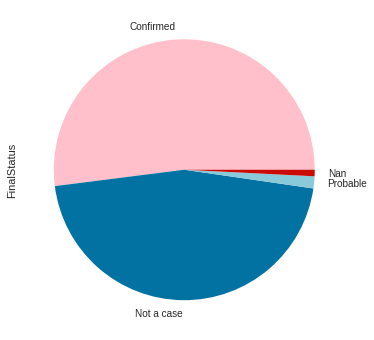

In [5]:
df.FinalStatus.value_counts(dropna=False).plot(kind='pie',labels=['Confirmed', 'Not a case', 'Probable', 'Nan'], colors=['pink', 'b', 'c', 'r'], fontsize=10, figsize=(6, 6))

In [6]:
df["Age"].head()

0    40.00
1    42.00
2     7.00
3    22.00
4     0.25
Name: Age, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871 entries, 0 to 870
Data columns (total 83 columns):
 #   Column                                                                    Non-Null Count  Dtype         
---  ------                                                                    --------------  -----         
 0   numero                                                                    871 non-null    object        
 1   Sex                                                                       871 non-null    object        
 2   Age                                                                       858 non-null    float64       
 3   Pregnant                                                                  0 non-null      float64       
 4   HealthCareWorker                                                          43 non-null     object        
 5   Occupation                                                                364 non-null    object        
 6   County    

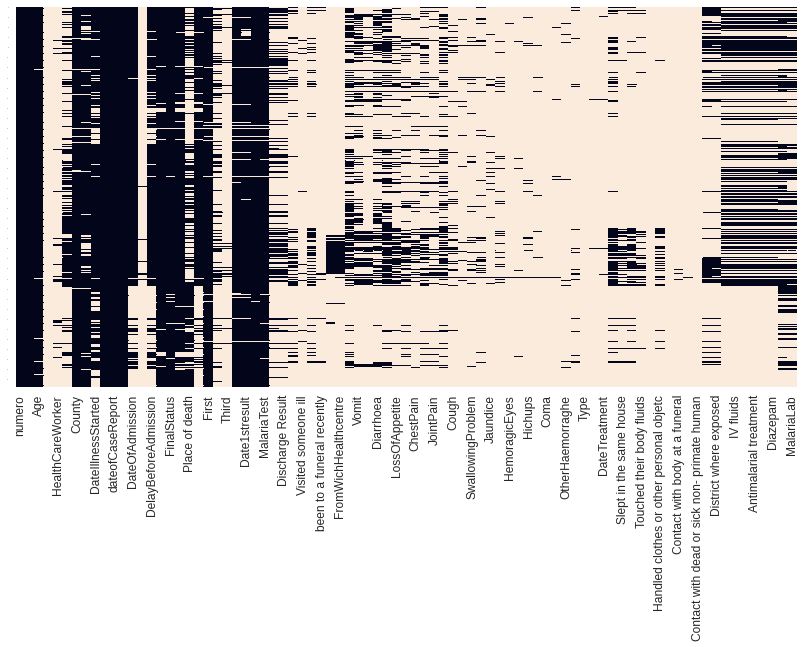

In [8]:
#sns.heatmap(df.isnull(), cbar=False)


f, ax = plt.subplots(figsize=(14, 7))
ax = sns.heatmap(df.isnull(), cbar=False)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 0)
#plt.savefig('Data_distribution_1.png')

### Numero

In [9]:
sum(df['Sex'].isna())

0

In [10]:
# Id of patients
df['numero'].nunique()

870

One numero has 2 records. 

In [11]:
df['numero'].value_counts(dropna=False).head()

F716    2
F174    1
F686    1
F650    1
F350    1
Name: numero, dtype: int64

In [12]:
df[df['numero'] == 'F716']

,numero,Sex,Age,Pregnant,HealthCareWorker,Occupation,County,District,DateIllnessStarted,CommunityCase,...,County where exposed,District where exposed,ORS,IV fluids,Antibiotic treatment,Antimalarial treatment,Morphine,Diazepam,CT Values,MalariaLab
828,F716,F,18.0,NaN,NaN,NaN,Lofa,Foya,2014-11-03,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
849,F716,F,37.0,NaN,NaN,NaN,Lofa,Foya,2014-11-25,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df['Age'].head()

0    40.00
1    42.00
2     7.00
3    22.00
4     0.25
Name: Age, dtype: float64

In [14]:
df.loc[849, 'numero'] = 'F716_bis'

### Sex

In [15]:
sum(df['Sex'].isna())

0

In [16]:
df['Sex'].value_counts(dropna=False).head()

F    434
M    433
m      3
f      1
Name: Sex, dtype: int64

In [17]:
dict_sex = {'m' : 'M', 'f' : 'F'}

def correct_sex(row):
    if row.Sex in dict_sex:
            return dict_sex[row.Sex]
    return row.Sex

df['Sex'] = df.apply(correct_sex,axis = 1)

In [18]:
df['Sex'].value_counts(dropna=False)

M    436
F    435
Name: Sex, dtype: int64

### Age

In [19]:
sum(df['Age'].isna())

13

In [20]:
df['Age'].head()

0    40.00
1    42.00
2     7.00
3    22.00
4     0.25
Name: Age, dtype: float64

In [21]:
df['Age'].mean()

31.06493395493395

In [22]:
df['Age'].median()

30.0

In [23]:
df['Age'].min()

0.0

In [24]:
df['Age'].max()

114.0

In [25]:
df['Age'].value_counts(dropna=False)

40.00    47
35.00    43
30.00    40
25.00    30
45.00    28
         ..
0.75      1
0.00      1
83.00     1
13.00     1
92.00     1
Name: Age, Length: 102, dtype: int64

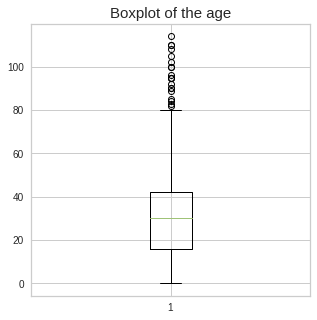

In [26]:
fig, ax = plt.subplots(figsize=(5,5))

ax.set_title("Boxplot of the age",size=15)
plt.boxplot(df.loc[~df['Age'].isna(),'Age'])
plt.show()

### Pregnant

In [27]:
sum(~df['Pregnant'].isna())

0

In [28]:
df.drop(columns= ['Pregnant'], inplace = True)

### HealthCareWorker

In [29]:
df['HealthCareWorker'].value_counts(dropna=False)

NaN    828
Y       29
N       14
Name: HealthCareWorker, dtype: int64

### Occupation

In [30]:
sum(df['Occupation'].isna())

507

In [31]:
df['Occupation'] = df['Occupation'] .str.lower()
df['Occupation'].value_counts(dropna=False).head()

NaN           507
farmer        112
child          86
student        75
house wife      8
Name: Occupation, dtype: int64

### County

In [32]:
sum(df['County'].isna())

25

In [33]:
df['County'] = df['County'].str.lower()
df['County'].value_counts(dropna=False).head()

lofa            781
sierra leone     34
NaN              25
bong             18
montserrado       9
Name: County, dtype: int64

### DateIllnessStarted

In [34]:
sum(df['DateIllnessStarted'].isna())

183

In [35]:
df['DateIllnessStarted_day'] = df['DateIllnessStarted'].dt.to_period('D')
df['DateIllnessStarted_month'] = df['DateIllnessStarted'].dt.to_period('M')

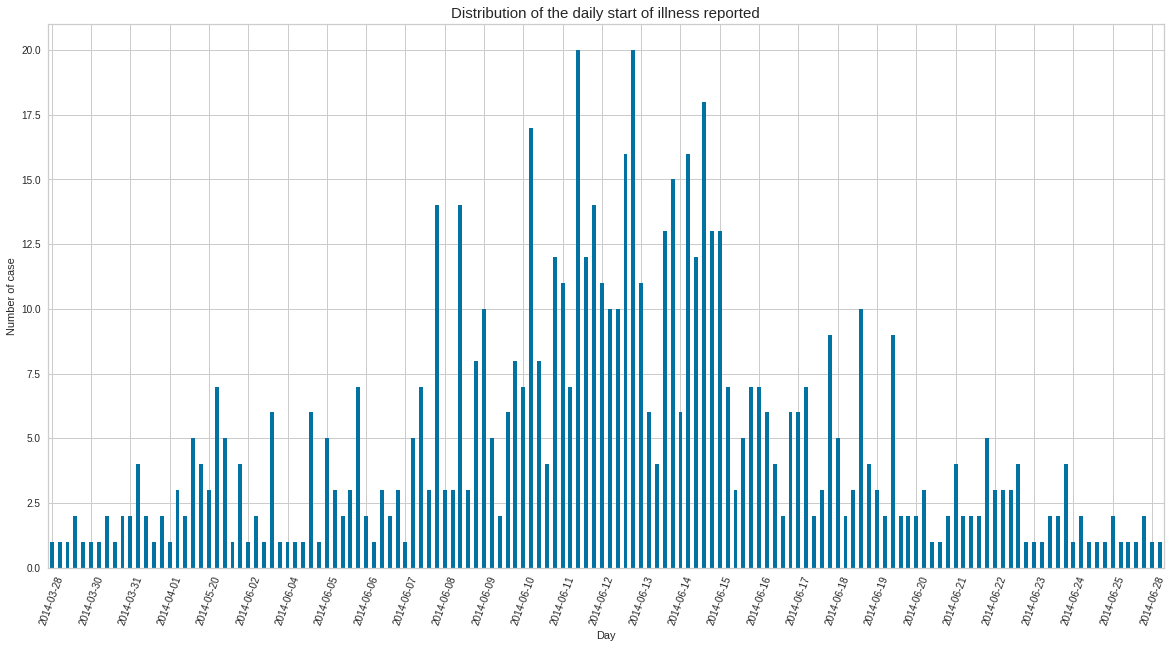

In [36]:
fig, ax = plt.subplots(figsize=(20,10))

df['DateIllnessStarted_day'].value_counts().sort_index().plot(kind ="bar")

ax.set_title("Distribution of the daily start of illness reported",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of case')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

### DateofCaseReport

In [37]:
sum(df['dateofCaseReport'].isna())

0

In [38]:
df['dateofCaseReport_day'] = df['dateofCaseReport'].dt.to_period('D')
df['dateofCaseReport_month'] = df['dateofCaseReport'].dt.to_period('M')

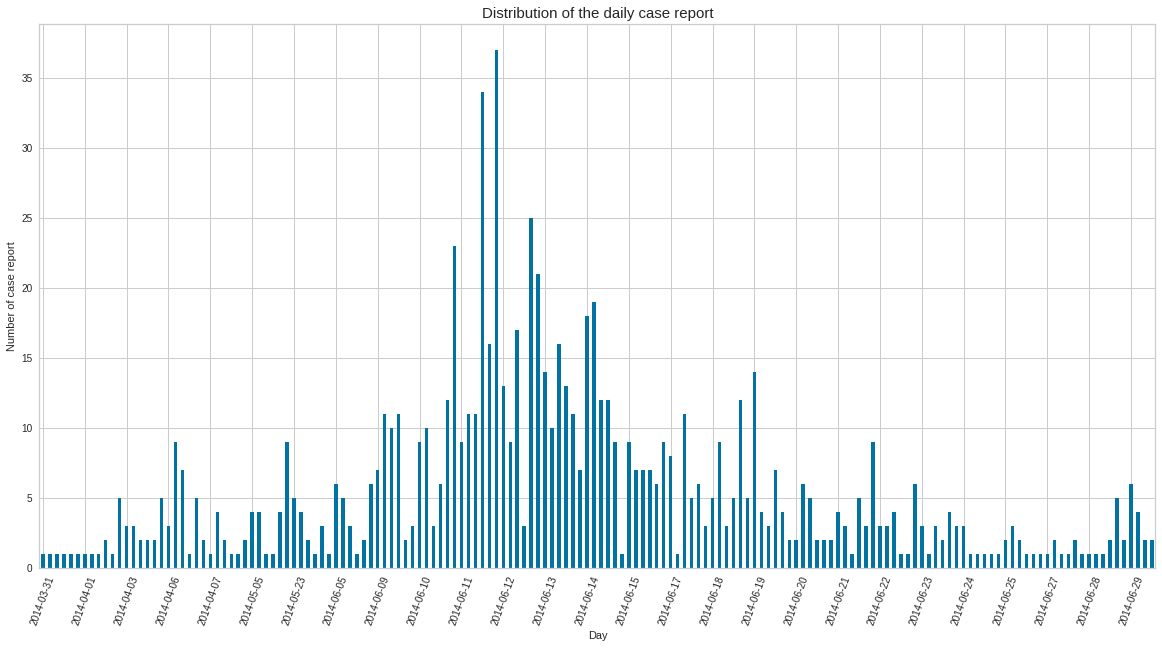

In [39]:
fig, ax = plt.subplots(figsize=(20,10))

df['dateofCaseReport_day'].value_counts(dropna=False).sort_index().plot(kind ="bar")

ax.set_title("Distribution of the daily case report",size=15)
ax.set_xlabel('Day')
ax.set_ylabel('Number of case report')
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

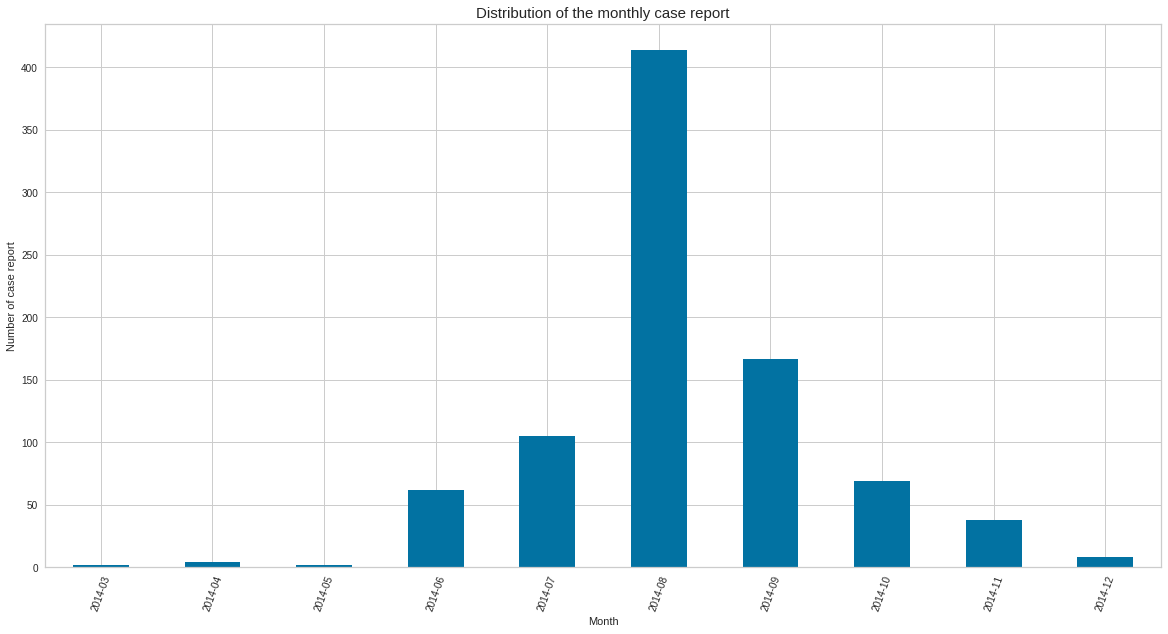

In [40]:
fig, ax = plt.subplots(figsize=(20,10))

df['dateofCaseReport_month'].value_counts(dropna=False).sort_index().plot(kind ="bar")

ax.set_title("Distribution of the monthly case report",size=15)
ax.set_xlabel('Month')
ax.set_ylabel('Number of case report')
#ax.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.xticks(rotation=70)
plt.show()

### Time between start of sickness and report

In [41]:
def compute_diff_days(row):
    if pd.isnull(row.DateIllnessStarted):
        return np.nan
    else: 
        return (row.dateofCaseReport - row.DateIllnessStarted)

In [42]:
df['Referraltime'] = df[['DateIllnessStarted','dateofCaseReport']].apply(compute_diff_days, axis = 1 )

In [43]:
df['Referraltime'].head()

0      NaT
1   1 days
2   1 days
3   5 days
4   1 days
Name: Referraltime, dtype: timedelta64[ns]

In [44]:
sum(df['Referraltime'].isna())

183

In [45]:
df['Referraltime'].value_counts().head()

3 days    127
2 days    102
1 days     86
4 days     78
7 days     67
Name: Referraltime, dtype: int64

In [46]:
df[df['Referraltime'] == '-29 days']

,numero,Sex,Age,HealthCareWorker,Occupation,County,District,DateIllnessStarted,CommunityCase,dateofCaseReport,...,Antimalarial treatment,Morphine,Diazepam,CT Values,MalariaLab,DateIllnessStarted_day,DateIllnessStarted_month,dateofCaseReport_day,dateofCaseReport_month,Referraltime
762,FF033,F,64.0,NaN,NaN,lofa,Voinjama,2014-08-17,Y,2014-07-19,...,NaN,NaN,NaN,24.05,0,2014-08-17,2014-08,2014-07-19,2014-07,-29 days


We have an odd value and we decide to drop it. 

In [47]:
df.drop(index = 762, inplace = True)

In [48]:
df_dif_status = df.groupby(['Referraltime','FinalStatus']).numero.count().unstack(fill_value=0)
df_dif_status.head()

FinalStatus,Confirmed,Not a Case,Probable
Referraltime,,,
0 days,33,18,1
1 days,40,45,1
2 days,63,38,1
3 days,78,48,1
4 days,55,20,3


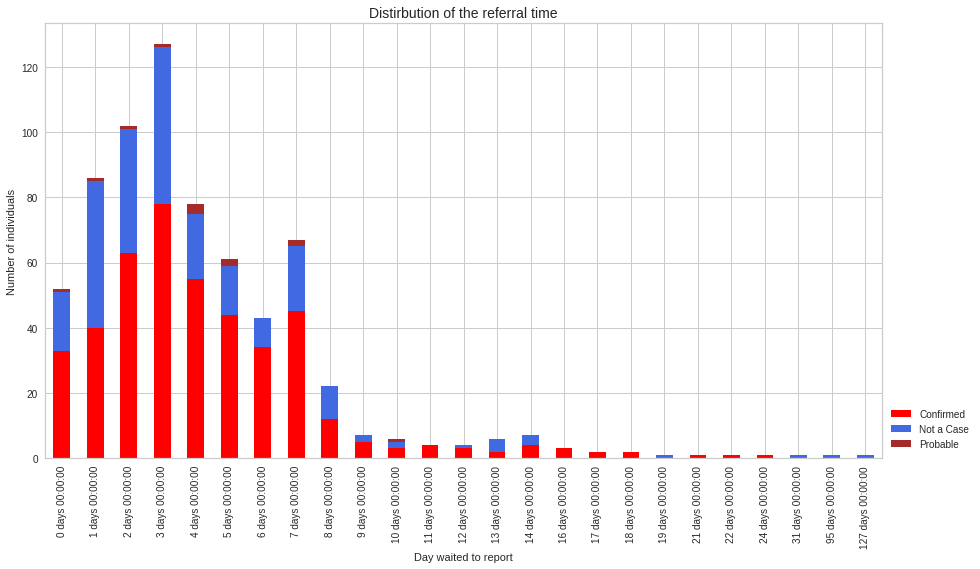

In [49]:
fig, ax = plt.subplots(figsize=(15,8))

df_dif_status.plot(kind='bar',stacked=True, ax=ax, color = ['red', 'royalblue', 'brown'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the referral time",size=14)
ax.set_xlabel('Day waited to report')
ax.set_ylabel('Number of individuals')
plt.show()

In [50]:
df_dif_exit = df.groupby(['Referraltime','TypeOfExit']).numero.count().unstack(fill_value=0)
df_dif_exit.head()

TypeOfExit,Cured,Died,Sent Home,Sent home,Transferred,died
Referraltime,,,,,,
0 days,9,25,10,5,0,0
1 days,14,28,29,11,2,1
2 days,19,51,22,7,0,0
3 days,26,54,35,10,0,0
4 days,23,37,12,4,1,0


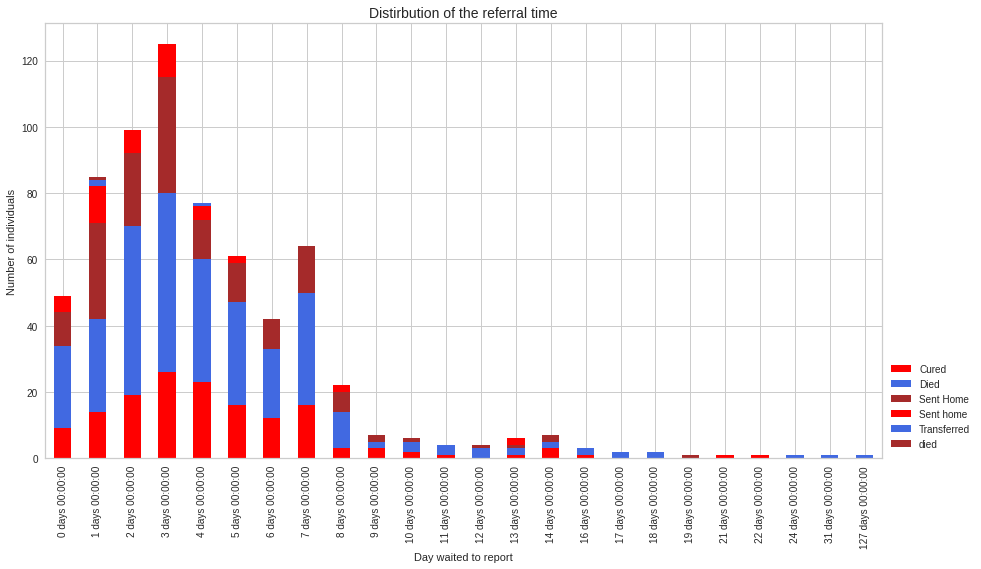

In [51]:
fig, ax = plt.subplots(figsize=(15,8))

df_dif_exit.plot(kind='bar',stacked=True, ax=ax, color = ['red', 'royalblue', 'brown'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the referral time",size=14)
ax.set_xlabel('Day waited to report')
ax.set_ylabel('Number of individuals')
plt.show()

### readmission

In [52]:
df['readmission'].value_counts(dropna=False)

NaN    852
Y       12
N        5
         1
Name: readmission, dtype: int64

### DelayBeforeAdmission

In [53]:
df_delay_case = df.groupby(['DelayBeforeAdmission','FinalStatus']).numero.count().unstack(fill_value=0)
df_delay_case.head()

FinalStatus,Confirmed,Not a Case,Probable
DelayBeforeAdmission,,,
0.0,26,18,1
1.0,36,40,1
2.0,56,35,0
3.0,71,48,1
4.0,53,20,3


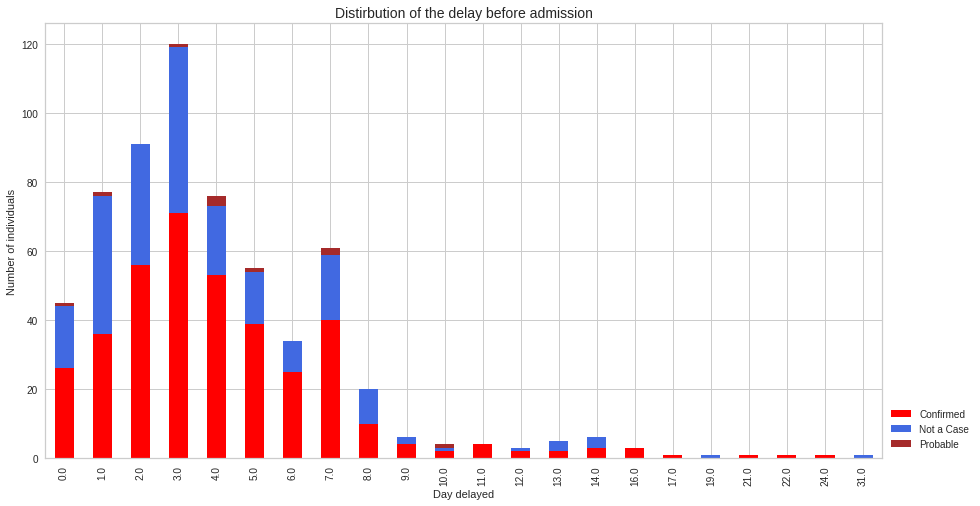

In [54]:
fig, ax = plt.subplots(figsize=(15,8))

df_delay_case.plot(kind='bar',stacked=True, ax=ax, color = ['red', 'royalblue', 'brown'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the delay before admission",size=14)
ax.set_xlabel('Day delayed')
ax.set_ylabel('Number of individuals')
plt.show()

In [55]:
df['TypeOfExit'] = df['TypeOfExit'].str.lower()

In [56]:
df_delay_exit = df.groupby(['DelayBeforeAdmission','TypeOfExit']).numero.count().unstack(fill_value=0)
df_delay_exit.head()

TypeOfExit,cured,died,sent home,transferred
DelayBeforeAdmission,,,,
0.0,10,17,15,0
1.0,14,23,38,1
2.0,18,39,31,0
3.0,26,46,45,0
4.0,24,34,16,1


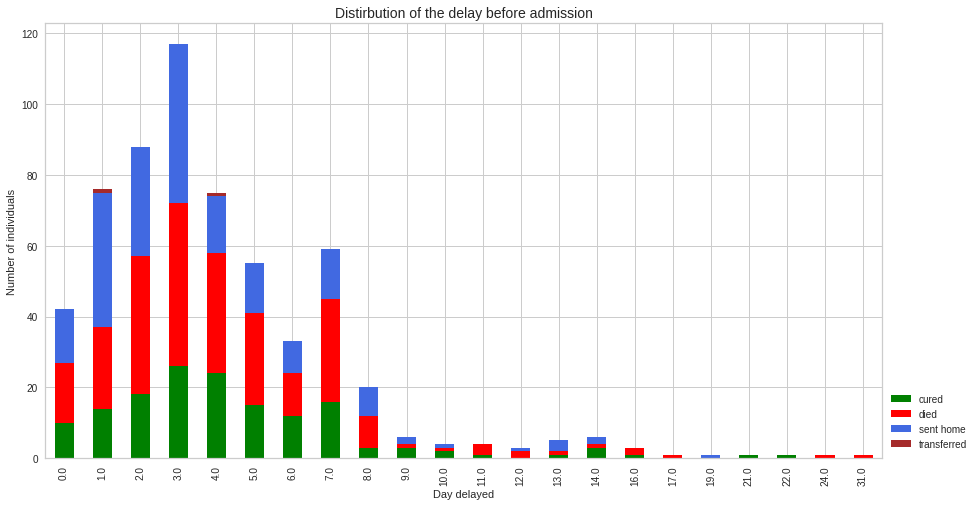

In [57]:
fig, ax = plt.subplots(figsize=(15,8))

df_delay_exit.plot(kind='bar',stacked=True, ax=ax, color = ['green', 'red','royalblue', 'brown'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the delay before admission",size=14)
ax.set_xlabel('Day delayed')
ax.set_ylabel('Number of individuals')
plt.show()

In [58]:
df_delay_exit['Mortality rate'] = df_delay_exit.apply(lambda row : row['died'] / sum(row), axis = 1)

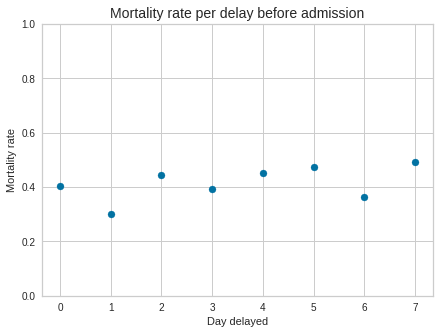

In [59]:
fig, ax = plt.subplots(figsize=(7,5))

delay_mr = df_delay_exit.loc[:7,'Mortality rate']

plt.scatter(delay_mr.index, delay_mr)
ax.set_title("Mortality rate per delay before admission",size=14)
ax.set_xlabel('Day delayed')
ax.set_ylabel('Mortality rate')
ax.set_ylim(0, 1) 
plt.show()

### TypeOfExit

In [60]:
sum(df['TypeOfExit'].isna())

28

In [61]:
df.loc[df['TypeOfExit'].isna(), 'FinalStatus'].value_counts(dropna=False)

Not a Case    24
Confirmed      3
NaN            1
Name: FinalStatus, dtype: int64

In [62]:
df['TypeOfExit'] = df['TypeOfExit'].fillna('unknown')

In [63]:
df['TypeOfExit'].value_counts(dropna=False)

died           427
sent home      257
cured          154
unknown         28
transferred      3
escaped          1
Name: TypeOfExit, dtype: int64

### FinalStatus

In [64]:
df['FinalStatus'].value_counts(dropna=False)

Confirmed     452
Not a Case    398
Probable       13
NaN             7
Name: FinalStatus, dtype: int64

In [65]:
pd.DataFrame(df.groupby(['FinalStatus','TypeOfExit']).numero.count())

numero
FinalStatus TypeOfExit         
Confirmed   cured           153
            died            296
            unknown           3
Not a Case  cured             1
            died            113
            sent home       257
            transferred       3
            unknown          24
Probable    died             13

### LenghtOfStay 

In [66]:
sum(df['LenghtOfStay'].isna())

214

In [67]:
df_lstay_case = df.groupby(['LenghtOfStay','FinalStatus']).numero.count().unstack(fill_value=0)
df_lstay_case.head()

FinalStatus,Confirmed,Not a Case,Probable
LenghtOfStay,,,
0.0,5,4,4
1.0,32,15,0
2.0,29,48,3
3.0,36,50,2
4.0,29,44,1


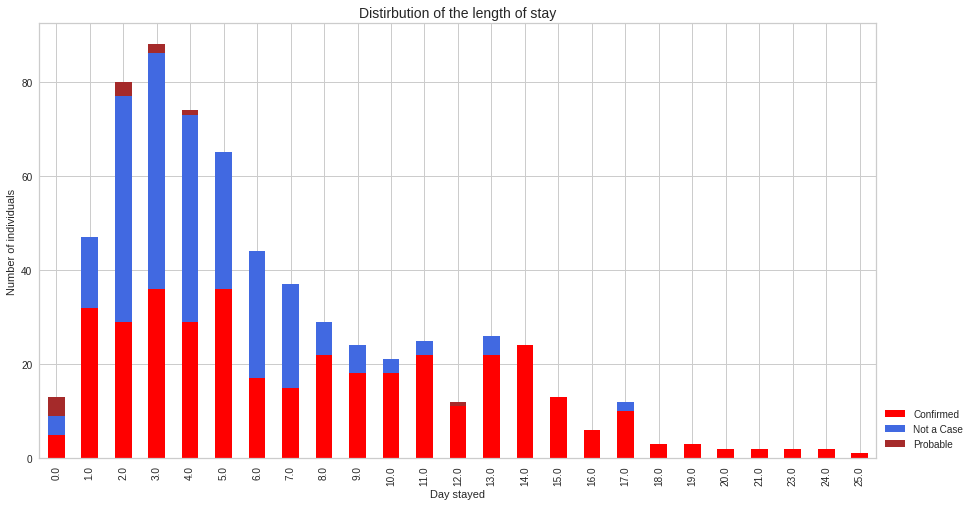

In [68]:
fig, ax = plt.subplots(figsize=(15,8))

df_lstay_case.plot(kind='bar',stacked=True, ax=ax, color = ['red', 'royalblue', 'brown'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the length of stay",size=14)
ax.set_xlabel('Day stayed')
ax.set_ylabel('Number of individuals')
plt.show()

In [69]:
df_lstay_exit = df.groupby(['LenghtOfStay','TypeOfExit']).numero.count().unstack(fill_value=0)
df_lstay_exit.head()

TypeOfExit,died,escaped,sent home,cured,transferred
LenghtOfStay,,,,,
0.0,13,1,0,0,0
1.0,35,0,12,0,0
2.0,34,0,46,0,0
3.0,39,0,49,0,0
4.0,30,0,41,2,1


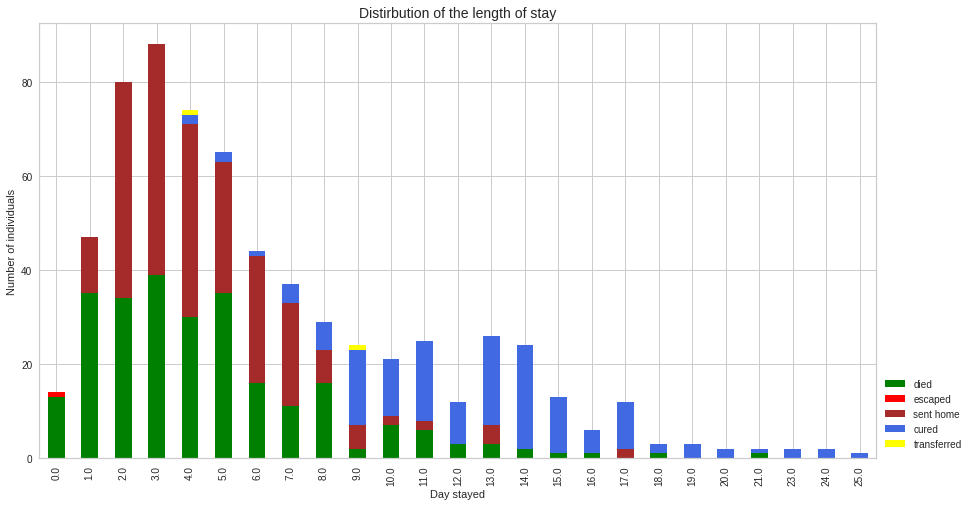

In [70]:
fig, ax = plt.subplots(figsize=(15,8))

df_lstay_exit.plot(kind='bar',stacked=True, ax=ax, color = ['green', 'red', 'brown', 'royalblue', 'yellow'])

plt.legend(loc="lower left", bbox_to_anchor=(1,0))
ax.set_title("Distirbution of the length of stay",size=14)
ax.set_xlabel('Day stayed')
ax.set_ylabel('Number of individuals')
plt.show()

### Test Result

In [71]:
df['First'].value_counts(dropna=False)

P      439
N      402
NaN     23
I        6
Name: First, dtype: int64

In [72]:
dict_result = {'P' : 'Positive', 'N' : 'Negative', 'I' : 'Inconclusive', np.nan : 'Not done'}

In [73]:
df['First'] = df['First'].apply(lambda x: dict_result[x])
df['Second'] = df['Second'].apply(lambda x: dict_result[x])
df['Third'] = df['Third'].apply(lambda x: dict_result[x])

In [74]:
df_tests_outcome = pd.DataFrame(df.groupby(['First','Second','Third', 'TypeOfExit','FinalStatus']).numero.count())
df_tests_outcome

numero
First        Second       Third    TypeOfExit  FinalStatus        
Inconclusive Inconclusive Not done died        Not a Case        1
                          Positive died        Confirmed         1
             Negative     Not done died        Not a Case        1
Negative     Negative     Negative sent home   Not a Case        6
                          Not done cured       Not a Case        1
                                   died        Not a Case        3
                                   sent home   Not a Case       81
                                   transferred Not a Case        1
                                   unknown     Not a Case        1
             Not done     Not done died        Not a Case      108
                                   sent home   Not a Case      166
                                   transferred Not a Case        2
                                   unknown     Not a Case       23
             Positive     Negative cured       Confirmed         1
                          Not done cured       Confirmed         2
                                   died        Confirmed         7
Not done     Not done     Not done cured       Confirmed         2
                                   died        Probable         13
                                   sent home   Not a Case        4
Positive     Inconclusive Negative died        Confirmed         1
             Negative     Negative cured       Confirmed         1
                          Not done cured       Confirmed        82
                                   died        Confirmed         2
             Not done     Not done cured       Confirmed        40
                                   died        Confirmed       283
                                   unknown     Confirmed         3
             Positive     Negative cured       Confirmed        23
                          Not done cured       Confirmed         2
                                   died        Confirmed         2

### MalariaTest

In [75]:
df['MalariaTest'] = df['MalariaTest'].str.lower()
df['MalariaTest'].value_counts(dropna=False)

negative        459
not done        146
positive        141
n/a              90
NaN              19
no info          12
inconclusive      2
postive           1
Name: MalariaTest, dtype: int64

In [76]:
dict_malaria = {'negative' : 'Negative', 'not done' : 'Unknown', 'positive' : 'Positive', 
                'n/a' : 'Unknown', 'no info' : 'Unknown', 'inconclusive' : 'Unknown', 
                'postive' : 'Positive', np.nan : 'Unknown'}

df['MalariaTest'] = df['MalariaTest'].apply(lambda x: dict_malaria[x])
df['MalariaTest'].value_counts(dropna=False)

Negative    459
Unknown     269
Positive    142
Name: MalariaTest, dtype: int64

In [77]:
pd.DataFrame(df.groupby(['MalariaTest', 'FinalStatus']).numero.count())

numero
MalariaTest FinalStatus        
Negative    Confirmed       276
            Not a Case      182
            Probable          1
Positive    Confirmed        65
            Not a Case       77
Unknown     Confirmed       111
            Not a Case      139
            Probable         12

### TypeOfExit 

In [78]:
df['TypeOfExit'].value_counts(dropna=False)

died           427
sent home      257
cured          154
unknown         28
transferred      3
escaped          1
Name: TypeOfExit, dtype: int64

### Contact

In [79]:
contacts = ['Someone ill in the familiy','Visited someone ill','somebody recently died in your family','been to a funeral recently']

In [80]:
df.loc[:,contacts]=df.loc[:,contacts].fillna('N')

In [81]:
df['Someone ill in the familiy'].value_counts(dropna=False)

N    724
Y    146
Name: Someone ill in the familiy, dtype: int64

In [82]:
df['Visited someone ill'].value_counts(dropna=False)

N    851
Y     19
Name: Visited someone ill, dtype: int64

In [83]:
df['somebody recently died in your family'].value_counts()

N    733
Y    137
Name: somebody recently died in your family, dtype: int64

In [84]:
df['been to a funeral recently'].value_counts(dropna=False)

N    851
Y     19
Name: been to a funeral recently, dtype: int64

In [85]:
df.loc[:,contacts]=df.loc[:,contacts].applymap(lambda x: 1 if x == 'Y' else 0)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 0 to 870
Data columns (total 87 columns):
 #   Column                                                                    Non-Null Count  Dtype          
---  ------                                                                    --------------  -----          
 0   numero                                                                    870 non-null    object         
 1   Sex                                                                       870 non-null    object         
 2   Age                                                                       857 non-null    float64        
 3   HealthCareWorker                                                          43 non-null     object         
 4   Occupation                                                                364 non-null    object         
 5   County                                                                    845 non-null    object         
 6   Di

### Details of type of contact with FHF patient

details_contact = ['Yes/No', 'Slept in the same house', 'Had direct physical contact', 'Touched their body fluids', 'had sexual relations',  
'Handled clothes or other personal objetc']              


### Symptoms since illness started

In [87]:
symptoms = ['fever', 'Vomit', 'Nausea', 'Diarrhoea', 'AstheniaWeakness', 'LossOfAppetite', 'AbdominalPain', 'ChestPain', 
'BoneMusclePain', 'JointPain','Headache', 'Cough', 'Breathlessness', 'SwallowingProblem',
'Sorethroat', 'Jaundice', 'Conjunctivitis', 'HemoragicEyes','SkinRash', 'Hichups', 'PainEyesSensitivityLight',
'Coma', 'ConfusedDisoriented', 'OtherHaemorraghe']

infos = ['Sex', 'Age', 'Referraltime']
tests = ['CT Values', 'MalariaTest']
outputs = ['FinalStatus', 'TypeOfExit']

In [88]:
df_ml = df[infos+ symptoms + tests + outputs].copy()
df_ml.head()

,Sex,Age,Referraltime,fever,Vomit,Nausea,Diarrhoea,AstheniaWeakness,LossOfAppetite,AbdominalPain,...,SkinRash,Hichups,PainEyesSensitivityLight,Coma,ConfusedDisoriented,OtherHaemorraghe,CT Values,MalariaTest,FinalStatus,TypeOfExit
0,M,40.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Probable,died
1,M,42.00,1 days,NaN,NaN,NaN,NaN,Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.91,Positive,Confirmed,died
2,M,7.00,1 days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.46,Negative,Confirmed,died
3,F,22.00,5 days,Y,Y,Y,Y,NaN,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,20.51,Negative,Confirmed,died
4,M,0.25,1 days,Y,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.30,Negative,Confirmed,died


In [89]:
df_ml

,Sex,Age,Referraltime,fever,Vomit,Nausea,Diarrhoea,AstheniaWeakness,LossOfAppetite,AbdominalPain,...,SkinRash,Hichups,PainEyesSensitivityLight,Coma,ConfusedDisoriented,OtherHaemorraghe,CT Values,MalariaTest,FinalStatus,TypeOfExit
0,M,40.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Probable,died
1,M,42.00,1 days,NaN,NaN,NaN,NaN,Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.91,Positive,Confirmed,died
2,M,7.00,1 days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.46,Negative,Confirmed,died
3,F,22.00,5 days,Y,Y,Y,Y,NaN,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,20.51,Negative,Confirmed,died
4,M,0.25,1 days,Y,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.30,Negative,Confirmed,died
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,M,5.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Not a Case,died
867,M,43.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Not a Case,died
868,M,80.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Not a Case,died
869,M,32.00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Negative,Not a Case,sent home


We drop the row that have only Nan values in the symptoms. (870 - 511)

In [90]:
df_ml.dropna(how='all', subset = symptoms)

,Sex,Age,Referraltime,fever,Vomit,Nausea,Diarrhoea,AstheniaWeakness,LossOfAppetite,AbdominalPain,...,SkinRash,Hichups,PainEyesSensitivityLight,Coma,ConfusedDisoriented,OtherHaemorraghe,CT Values,MalariaTest,FinalStatus,TypeOfExit
1,M,42.00,1 days,NaN,NaN,NaN,NaN,Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.91,Positive,Confirmed,died
2,M,7.00,1 days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.46,Negative,Confirmed,died
3,F,22.00,5 days,Y,Y,Y,Y,NaN,NaN,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,20.51,Negative,Confirmed,died
4,M,0.25,1 days,Y,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,26.30,Negative,Confirmed,died
5,M,8.00,4 days,Y,NaN,NaN,NaN,NaN,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Positive,Not a Case,sent home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,F,30.00,2 days,Y,NaN,NaN,NaN,Y,Y,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,16.24,Negative,Confirmed,died
822,F,25.00,2 days,Y,Y,Y,Y,Y,Y,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,17.11,Negative,Confirmed,died
823,M,46.00,0 days,Y,Y,Y,Y,Y,Y,Y,...,NaN,NaN,NaN,NaN,NaN,NaN,18.54,Negative,Confirmed,unknown
824,M,43.00,2 days,NaN,Y,Y,Y,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Negative,Not a Case,unknown


In [91]:
df_ml.dropna(how='all', subset = symptoms, inplace = True) 
df_ml[symptoms] = df_ml[symptoms].fillna('N')
dict_binary_symptoms = {'Y' : 1, 'N' : 0}
df_ml[symptoms] = df_ml[symptoms].applymap(lambda x: int(dict_binary_symptoms[x]))
df_ml.head()

,Sex,Age,Referraltime,fever,Vomit,Nausea,Diarrhoea,AstheniaWeakness,LossOfAppetite,AbdominalPain,...,SkinRash,Hichups,PainEyesSensitivityLight,Coma,ConfusedDisoriented,OtherHaemorraghe,CT Values,MalariaTest,FinalStatus,TypeOfExit
1,M,42.00,1 days,0,0,0,0,1,0,0,...,0,0,0,0,0,0,14.91,Positive,Confirmed,died
2,M,7.00,1 days,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18.46,Negative,Confirmed,died
3,F,22.00,5 days,1,1,1,1,0,0,1,...,0,0,0,0,0,0,20.51,Negative,Confirmed,died
4,M,0.25,1 days,1,0,0,0,0,0,0,...,0,0,0,0,0,0,26.30,Negative,Confirmed,died
5,M,8.00,4 days,1,0,0,0,0,1,0,...,0,0,0,0,0,0,NaN,Positive,Not a Case,sent home


In [92]:
df_ml[symptoms+outputs].groupby(outputs).sum()

fever  Vomit  Nausea  Diarrhoea  AstheniaWeakness  \
FinalStatus TypeOfExit                                                       
Confirmed   cured           90     70      45         72                87   
            died           135    123      76        118               128   
            unknown          1      1       1          1                 1   
Not a Case  died             6      5       5          1                 7   
            sent home      129     70      30         63               110   
            transferred      2      1       1          1                 1   
            unknown          6      3       2          3                 2   
Probable    died             3      2       0          3                 1   

                         LossOfAppetite  AbdominalPain  ChestPain  \
FinalStatus TypeOfExit                                              
Confirmed   cured                    52             42         29   
            died                     81             64         43   
            unknown                   1              1          1   
Not a Case  died                      5              3          4   
            sent home                59             70         41   
            transferred               0              1          0   
            unknown                   0              3          1   
Probable    died                      1              3          0   

                         BoneMusclePain  JointPain  ...  Sorethroat  Jaundice  \
FinalStatus TypeOfExit                              ...                         
Confirmed   cured                    37         22  ...          16         5   
            died                     68         37  ...          32         4   
            unknown                   1          1  ...           0         0   
Not a Case  died                      2          2  ...           2         0   
            sent home                61         54  ...          18        13   
            transferred               1          1  ...           0         0   
            unknown                   2          2  ...           1         0   
Probable    died                      0          0  ...           0         1   

                         Conjunctivitis  HemoragicEyes  SkinRash  Hichups  \
FinalStatus TypeOfExit                                                      
Confirmed   cured                    11              0         3        5   
            died                     25              1         1       12   
            unknown                   1              0         0        0   
Not a Case  died                      0              0         0        1   
            sent home                 5              0         3        7   
            transferred               0              0         0        1   
            unknown                   0              0         0        0   
Probable    died                      0              0         0        2   

                         PainEyesSensitivityLight  Coma  ConfusedDisoriented  \
FinalStatus TypeOfExit                                                         
Confirmed   cured                               4     0                    4   
            died                                5     1                    7   
            unknown                             0     0                    0   
Not a Case  died                                0     0                    1   
            sent home                           1     0                    0   
            transferred                         0     0                    0   
            unknown                             0     0                    0   
Probable    died                                0     0                    1   

                         OtherHaemorraghe  
FinalStatus TypeOfExit                     
Confirmed   cured                       4  
            died                      

# ML models

In [93]:
df_ml['Sex'] = df_ml['Sex'].apply(lambda x: 1 if x == 'M' else 0)

In [94]:
df_ml['Referraltime'] = df_ml['Referraltime'].apply(lambda x: x.days)

**Setting 1 Triage :** Using only the personnal informations and the symptoms. We want to find out if the patient has Ebola (FinalStatus)

In [95]:
from sklearn.preprocessing import StandardScaler

#select the features needed
df_triage = df_ml[infos+ symptoms+ ['FinalStatus']]
df_triage = df_triage[(df_triage['FinalStatus'] != 'Probable') & ~(df_triage['FinalStatus'].isna())]

#transform the dependent variable
dict_fstatus = {'Confirmed' : 1, 'Not a Case' : 0}
df_triage['FinalStatus'] = df_triage['FinalStatus'].apply(lambda x : dict_fstatus[x]) 
df_triage.dropna(how='any',inplace= True)


In [96]:
X_ebo_ml = df_triage.drop(columns="FinalStatus")
y_ebo_ml = df_triage['FinalStatus']

## Data visualization

### Correlation

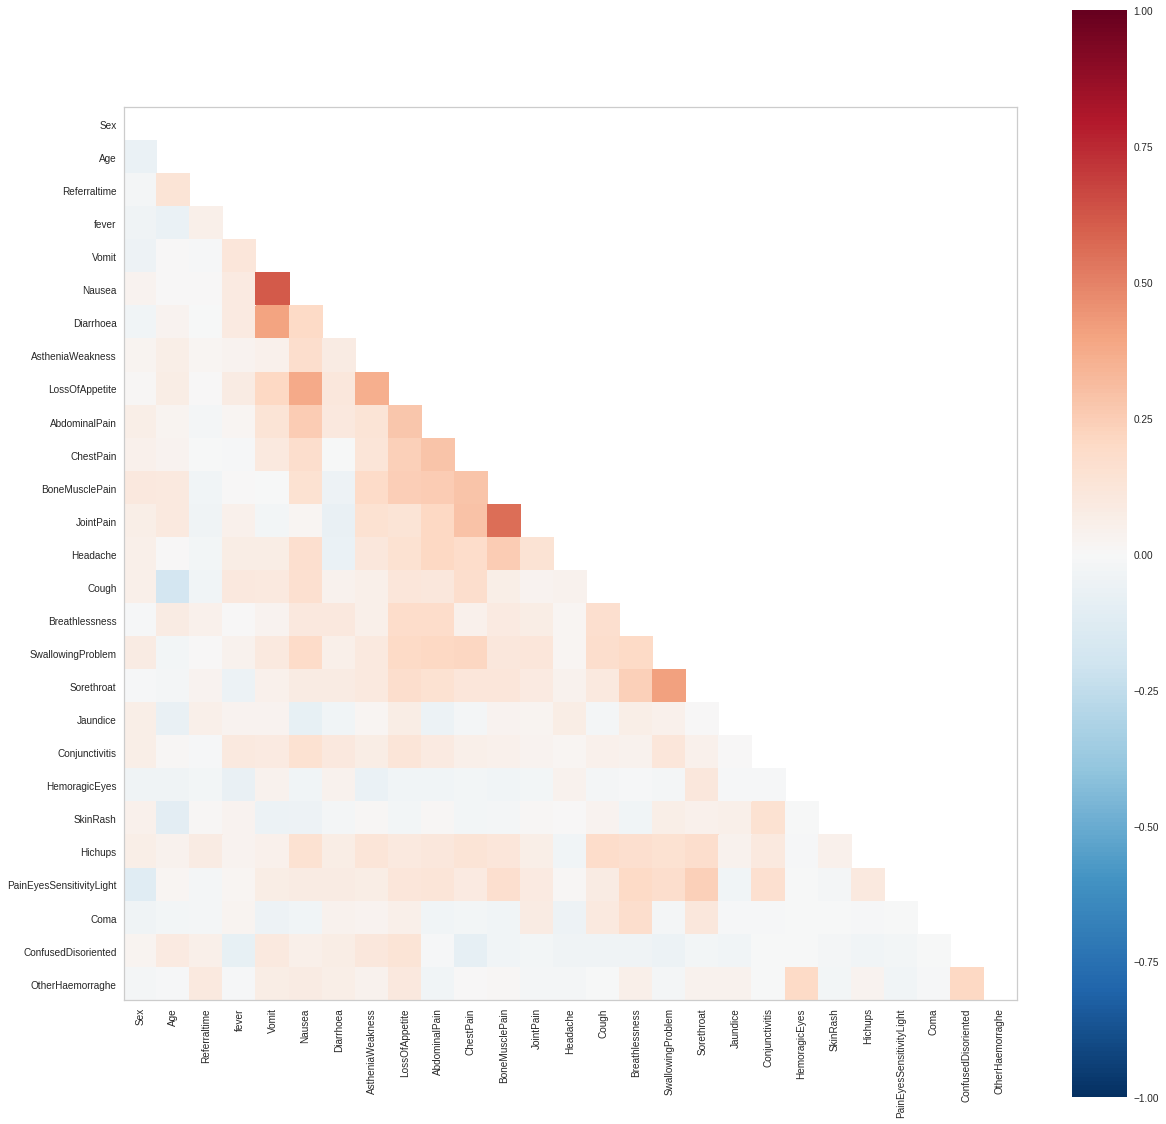

In [97]:
Corr_vision(X_ebo_ml)

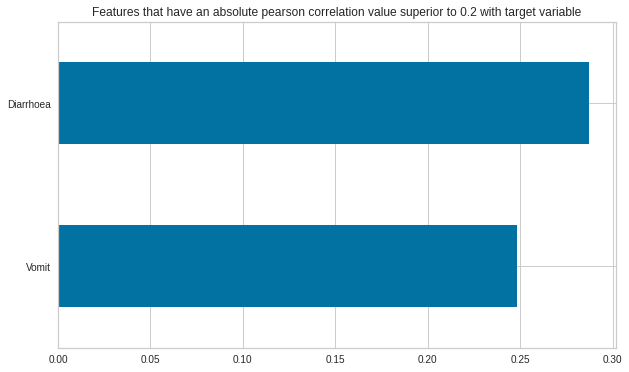

In [98]:
## Correlation with target label 

X_y = X_ebo_ml.join(y_ebo_ml)
corr_matrix = X_y.corr()

corr_y = corr_matrix['FinalStatus']
threshold = 0.2
fig, ax = plt.subplots(figsize=(10,6))
corr_y[corr_y.index[abs(corr_y) > threshold].tolist()].drop('FinalStatus').plot(kind='barh')
plt.title('Features that have an absolute pearson correlation value superior to {} with target variable'.format(threshold))
plt.show()

The values above are "correlated" with the output variable 'Finalstatus' (ebola outcome), we expect them to be considered important during the model.

### Class imbalance

Balance is important in order to get a reliable accuracy for unseen datas, if imbalanced, steps need to be taken in order to take this into account. 
A good metric to look at is precision, recall and F1, this is discussed in the report. 

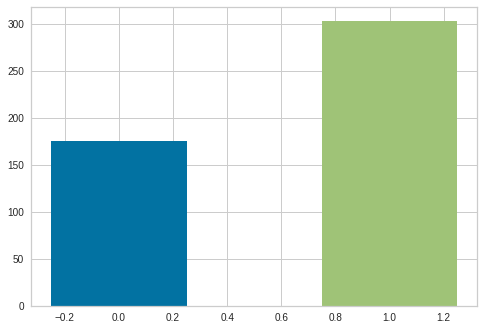

In [99]:
Imbalance(y_ebo_ml)

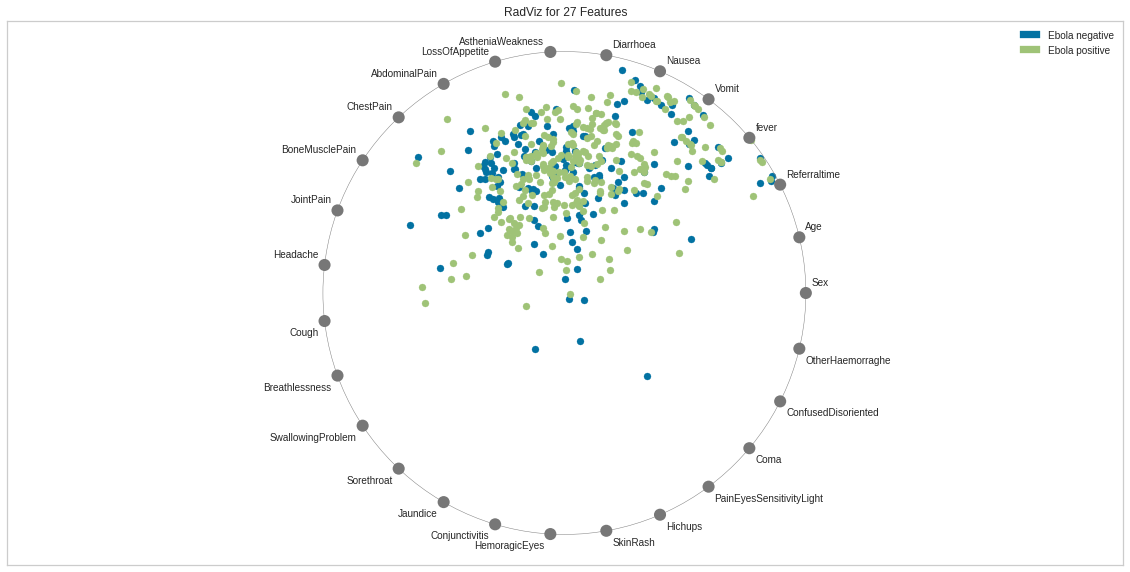

In [100]:
Rad_vision(X_ebo_ml, y_ebo_ml)

Looking at the figure above, we get no real difference between ebola negative and ebola positive patients.

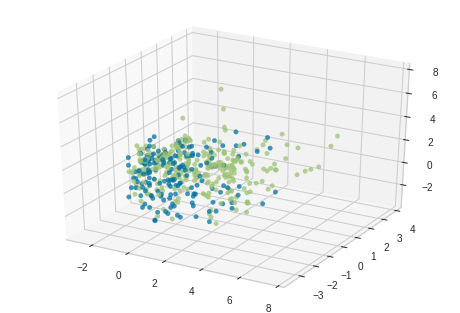

In [101]:
PCA_vision_3D(X_ebo_ml, y_ebo_ml)

In [102]:
from sklearn.decomposition import PCA
k = 2 # Number of components
pca = PCA(n_components = k)
X_new = pca.fit_transform(X_ebo_ml)
y_new = y_ebo_ml.copy()


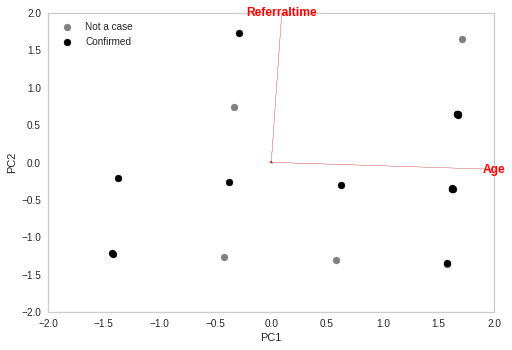

In [103]:
def myplot(X_new,y_new,coeff,labels=None):
    xs = X_new[:,0]
    ys = X_new[:,1]
    n = coeff.shape[0]
    cdict = {0: 'gray', 1: 'black'}
    ldict = {0: 'Not a case', 1: 'Confirmed'}
    fig, ax = plt.subplots()
    for g in np.unique(y_new):
        ix = np.where(y_new == g)
        ax.scatter(xs[ix], ys[ix], c = cdict[g], label = ldict[g])
    for i in range(n):
        factor_ = 2.8
        plt.arrow(0, 0, coeff[i,0]*factor_, coeff[i,1]*factor_,color = 'r',alpha = 0.5)
        if labels is None and np.linalg.norm([coeff[i,0], coeff[i,1]])>0.9:
            plt.text(coeff[i,0]* 2, coeff[i,1] * 2, str(X_ebo_ml.columns[i]), color = 'red', ha = 'center', va = 'center', fontsize=12, weight='bold')
    
    ax.legend()
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.show()
    
#Call the function. Use only the 2 PCs.
myplot(X_new, y_new, np.transpose(pca.components_[0:2, :]))


Let us apply PCA but dropping the sex, age and referraltime 

In [104]:
def myplot(X_new,y_new,coeff,labels=None):
    xs = X_new[:,0]
    ys = X_new[:,1]
    n = coeff.shape[0]
    cdict = {0: 'blue', 1: 'pink'}
    ldict = {0: 'Not a case', 1: 'Confirmed'}
    fig, ax = plt.subplots()
    for g in np.unique(y_new):
        ix = np.where(y_new == g)
        ax.scatter(xs[ix], ys[ix], c = cdict[g], label = ldict[g])
    for i in range(n):
        factor_ = 2.8
        plt.arrow(0, 0, coeff[i,0]*factor_, coeff[i,1]*factor_,color = 'r',alpha = 0.5)
        if labels is None and np.linalg.norm([coeff[i,0], coeff[i,1]])>0.3:
            plt.text(coeff[i,0]* 3, coeff[i,1] * 3, str(X_ebo_ml.columns[i]), color = 'black', ha = 'center', va = 'center', fontsize=12, weight='bold')
    
    ax.legend()
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    plt.show()

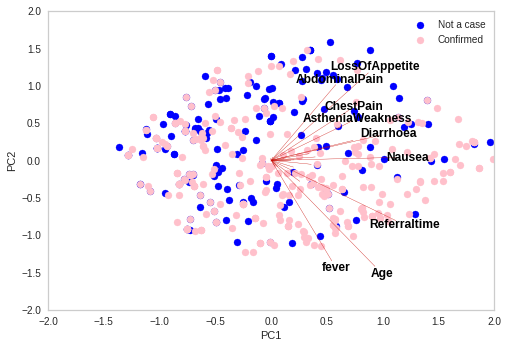

In [105]:
X_drop = X_ebo_ml.drop(columns=['Sex', 'Age', 'Referraltime'])

# apply PCA 
k = 2
pca = PCA(n_components = k)
X_new = pca.fit_transform(X_drop)
y_new = y_ebo_ml.copy()

#Call the function. Use only the 2 PCs.
myplot(X_new, y_new, np.transpose(pca.components_[0:2, :]))

### Split train/test

Before standardizing, we need to make sure that the dataset is split between train and test !
This is to make sure that the "way" we standardize our train set is "the base" as to how we standardize our test set.

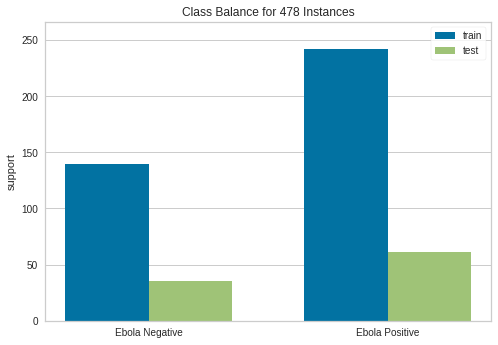

In [106]:

X_ebo_train, X_ebo_test, y_ebo_train, y_ebo_test = train_test_split(X_ebo_ml, y_ebo_ml, test_size=0.2, random_state=0, stratify=y_ebo_ml)


# Instantiate the visualizer
visualizer = ClassBalance(labels=['Ebola Negative', 'Ebola Positive'])

visualizer.fit(y_ebo_train, y_ebo_test)        # Fit the data to the visualizer
visualizer.show()                      # Finalize and render the figure
plt.show()

##### Normalizing the data


In [107]:
scaler = StandardScaler()
numerical_col = ['Age','Referraltime']
X_ebo_train.loc[:,numerical_col] = scaler.fit_transform(X_ebo_train[numerical_col])
X_ebo_test.loc[:,numerical_col] = scaler.transform(X_ebo_test[numerical_col])

/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/lavinia/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [108]:
df_triage[symptoms]



,fever,Vomit,Nausea,Diarrhoea,AstheniaWeakness,LossOfAppetite,AbdominalPain,ChestPain,BoneMusclePain,JointPain,...,Sorethroat,Jaundice,Conjunctivitis,HemoragicEyes,SkinRash,Hichups,PainEyesSensitivityLight,Coma,ConfusedDisoriented,OtherHaemorraghe
1,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,1,0,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
822,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
823,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
824,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Least squares

In [109]:
import statsmodels.api as sm

X = sm.add_constant(df_triage.loc[:, df_triage.columns != 'FinalStatus'])
y = df_triage['FinalStatus']
#normalize the continuous variables
scaler = StandardScaler()

X[['Age','Referraltime']] = scaler.fit_transform(X[['Age','Referraltime']])

# Model
est_OLS = sm.OLS(y, X.astype(float)).fit()
print(est_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:            FinalStatus   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     3.993
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           3.39e-10
Time:                        12:09:48   Log-Likelihood:                -277.81
No. Observations:                 478   AIC:                             611.6
Df Residuals:                     450   BIC:                             728.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Logistic

In [110]:


est_logit = sm.Logit(y, X.astype(float)).fit()
print(est_logit.summary())

         Current function value: 0.546278
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            FinalStatus   No. Observations:                  478
Model:                          Logit   Df Residuals:                      450
Method:                           MLE   Df Model:                           27
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.1683
Time:                        12:09:48   Log-Likelihood:                -261.12
converged:                      False   LL-Null:                       -313.98
Covariance Type:            nonrobust   LLR p-value:                 2.917e-11
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1280      0.309     -0.415      0.678      -0.733       0.477
Sex                    

/home/lavinia/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


We can see terrible r² values and we'll proceed to do some feature selection in order to improve the model

#### Backward Elimination

- Feed all possible features to the model
- Compute perfomance of model and remove worst perfoming features until stopping criterion



In [111]:
#### For Least square

X = df_triage.loc[:, df_triage.columns != 'FinalStatus']
y = df_triage['FinalStatus']

#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['Vomit', 'Diarrhoea', 'AstheniaWeakness', 'AbdominalPain', 'JointPain', 'SwallowingProblem', 'Jaundice', 'Conjunctivitis']


In [112]:
## Assert the model with new features
X = sm.add_constant(df_triage.loc[:, selected_features_BE])
y = df_triage['FinalStatus']

est_OLS = sm.OLS(y, X.astype(float)).fit()
print(est_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:            FinalStatus   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     12.22
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           6.30e-16
Time:                        12:09:49   Log-Likelihood:                -283.90
No. Observations:                 478   AIC:                             585.8
Df Residuals:                     469   BIC:                             623.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4457      0.04

### Logistic regression Backward elimation

In [113]:
X = df_triage.loc[:, df_triage.columns != 'FinalStatus']
y = df_triage['FinalStatus']

#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.Logit(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

         Current function value: 0.546278
         Iterations: 35


/home/lavinia/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


         Current function value: 0.547038
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.548212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548257
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548439
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.548871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.549194
         Iterations 7
Optimization ter

/home/lavinia/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [114]:
### Update the model with the selected features 
X = sm.add_constant(df_triage.loc[:, selected_features_BE])
y = df_triage['FinalStatus']

est_Logit = sm.Logit(y, X.astype(float)).fit()
print(est_Logit.summary())

Optimization terminated successfully.
         Current function value: 0.566194
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            FinalStatus   No. Observations:                  478
Model:                          Logit   Df Residuals:                      470
Method:                           MLE   Df Model:                            7
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.1380
Time:                        12:09:49   Log-Likelihood:                -270.64
converged:                       True   LL-Null:                       -313.98
Covariance Type:            nonrobust   LLR p-value:                 5.966e-16
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0473      0.175     -0.270      0.788      -0.391       0.296
Vomit   

The Pseudo-R^2 indicates that the model is not a good fit. 

#### Recursive Feature Elimination
The Recursive Feature Elimination (RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance. The RFE method takes the model to be used and the number of required features as input. It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature.

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

X = df_triage.loc[:, df_triage.columns != 'FinalStatus']
y = df_triage['FinalStatus']

#no of features 
nof_list=np.arange(1, len(X.columns)+1) 

highest_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    #mean accuracy
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>highest_score):
        highest_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, highest_score))

Optimum number of features: 24
Score with 24 features: 0.150128


In [116]:
from sklearn.linear_model import LogisticRegression

X = df_triage.loc[:, df_triage.columns != 'FinalStatus']
y = df_triage['FinalStatus']

#no of features 
nof_list=np.arange(1, len(X.columns)+1)   

highest_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression(max_iter = 200)
    rfe = RFE(model,n_features_to_select=nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>highest_score):
        highest_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, highest_score))

Optimum number of features: 11
Score with 11 features: 0.652778


In [117]:
## The RFE computed the number of features we should select (11)

cols = np.array(X.columns)
model = LogisticRegression(max_iter = 200)

#Initializing RFE model
rfe = RFE(model, n_features_to_select=11)   

#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  

#Fitting the data to model
model.fit(X_rfe,y) 
print("R_squared: " + str(model.score(X_rfe, y)))
print(cols[rfe.support_])
print(model.coef_)

R_squared: 0.6861924686192469
['Vomit' 'Diarrhoea' 'AbdominalPain' 'BoneMusclePain' 'JointPain'
 'SwallowingProblem' 'Jaundice' 'Conjunctivitis'
 'PainEyesSensitivityLight' 'ConfusedDisoriented' 'OtherHaemorraghe']
[[ 0.73719789  0.9163944  -0.62817269  0.41002439 -0.7728139   0.77122897
  -0.90899767  1.32422324  0.42577873  0.99245697 -0.41164003]]


#### Ensemble Methods
Embedded methods are a catch-all group of techniques which perform feature selection as part of the model construction process. The exemplar of this approach is the LASSO method for constructing a linear model, which penalizes the regression coefficients with an L1 penalty, shrinking many of them to zero. Any features which have non-zero regression coefficients are 'selected' by the LASSO algorithm.

In [118]:
from sklearn.linear_model import LassoCV
X = df_triage.loc[:, df_triage.columns != 'FinalStatus']
y = df_triage['FinalStatus']

reg = LassoCV()
reg.fit(X, y)

print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 0.007666
Best score using built-in LassoCV: 0.158719


In [119]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 13 variables and eliminated the other 14 variables


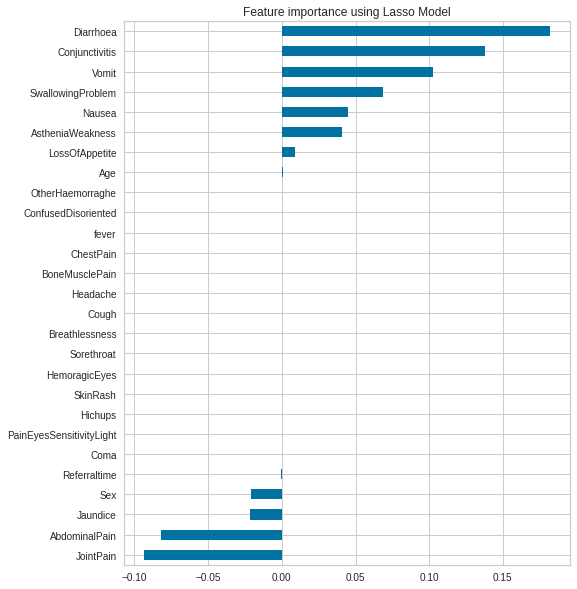

In [120]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

# Let us try some more "complex" and easily interpretable models

### Decision Trees
We did a few trees of varying depth. The problem is overfitting, which is fought with random forests. 

In [121]:
from sklearn import tree

###### If you would like to export the following trees, replace the number preceeding the (denoted by '?') q by your interested tree. Where this number corresponds to the number of questions asked by the doctor 


from sklearn import tree
import graphviz
dot_data_?q = tree.export_graphviz(clf?q, 
                                out_file=None, 
                                feature_names=X.columns,
                                rounded=True)
graph_?q = graphviz.Source(dot_data_?q)
graph_?q.render("Decision_tree_?_q")

##### What happens when you only can ask one question ?

In [122]:

clf1q = tree.DecisionTreeClassifier(max_depth=1)
clf1q = clf1q.fit(X_ebo_train, y_ebo_train)


DecisionTreeClassifier:
On training we get an Accuracy 0.6387434554973822, an AUC 0.6516528925619834 and F1 score 0.6790697674418603 
For test we get an Accuracy 0.65625, an AUC 0.6381733021077283 and F1 score 0.7226890756302522


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


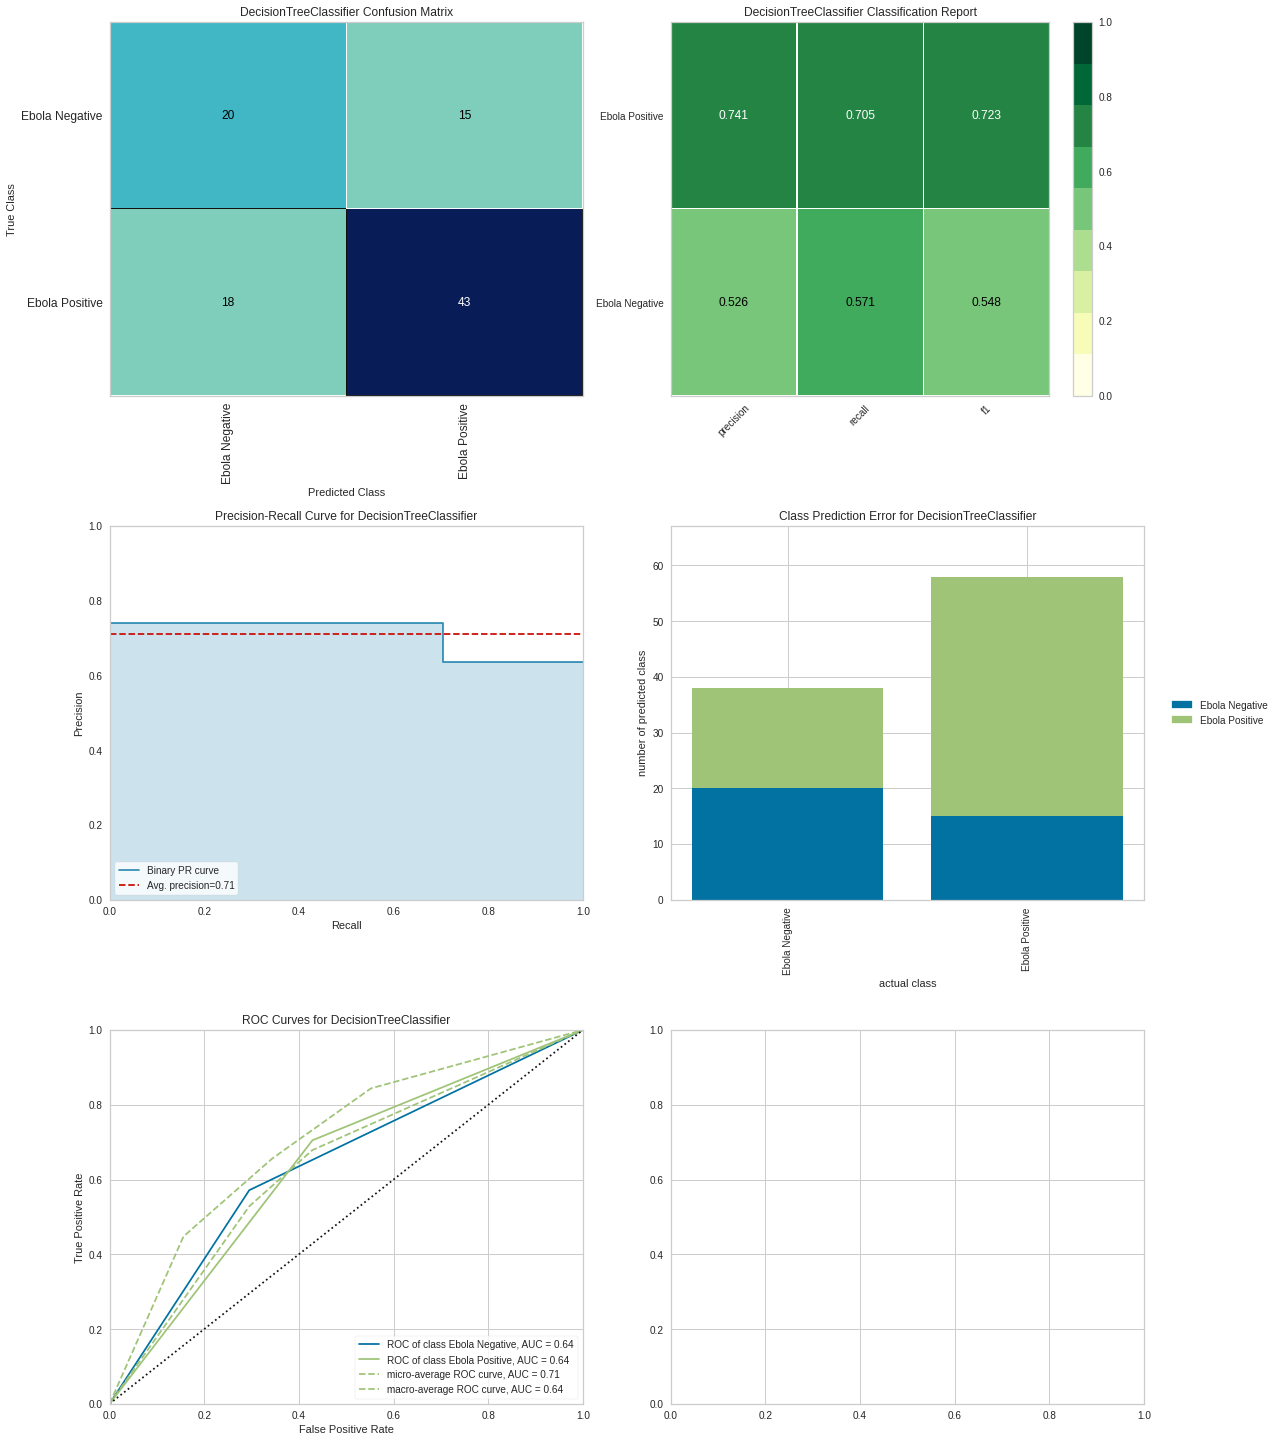

Don't have feature importance




In [123]:
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, clf1q)

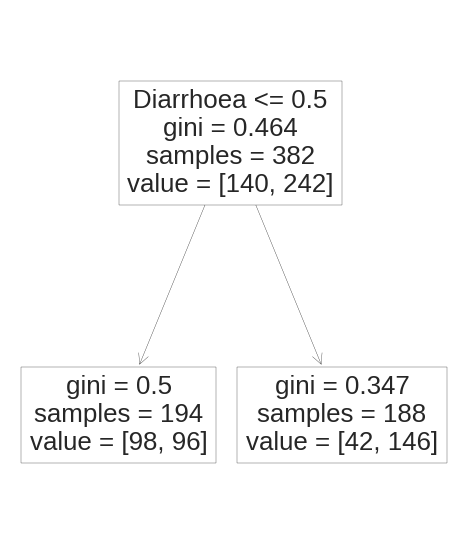

In [124]:
tree.plot_tree(clf1q,feature_names=X.columns)
fig = matplotlib.pyplot.gcf()

#fig.savefig('tree_1_question.png')
plt.show()


DecisionTreeClassifier:
On training we get an Accuracy 0.6701570680628273, an AUC 0.6794569067296341 and F1 score 0.7123287671232877 
For test we get an Accuracy 0.65625, an AUC 0.6442622950819672 and F1 score 0.7179487179487181


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


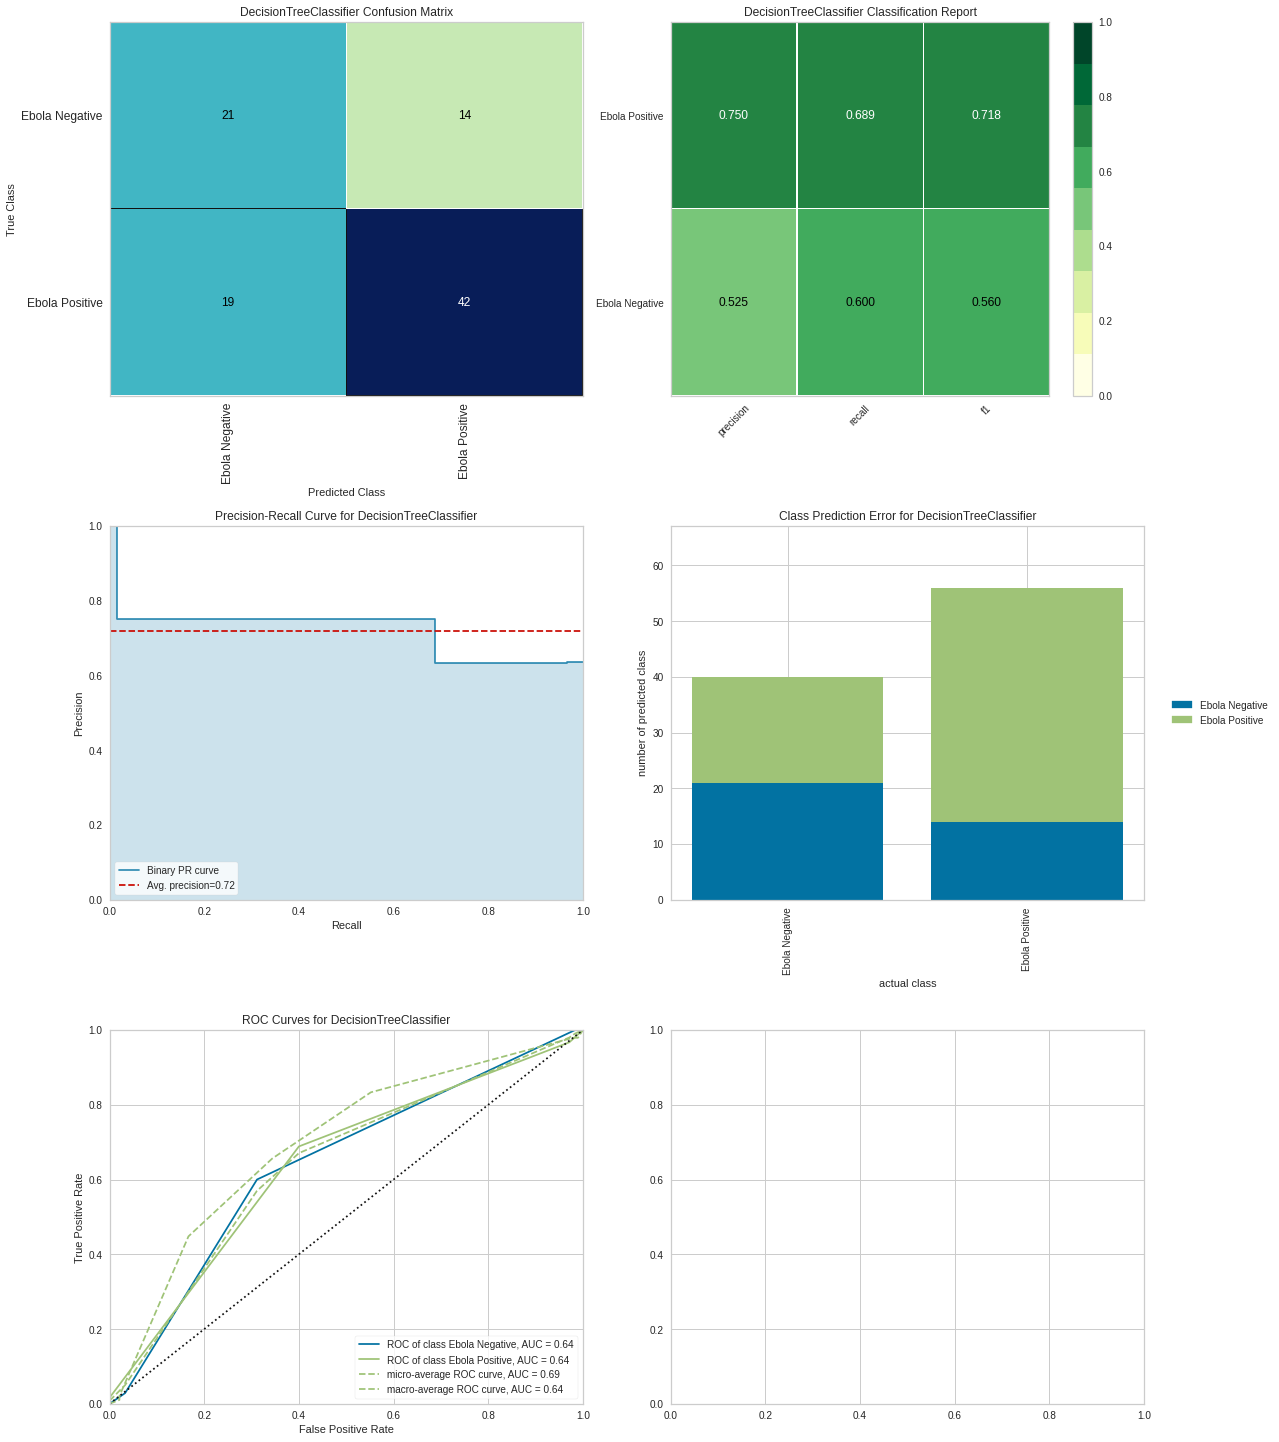

Don't have feature importance




In [125]:
# What happens when you only can ask two question ?

clf2q = tree.DecisionTreeClassifier(max_depth=2)
clf2q = clf2q.fit(X_ebo_train, y_ebo_train)

score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, clf2q)


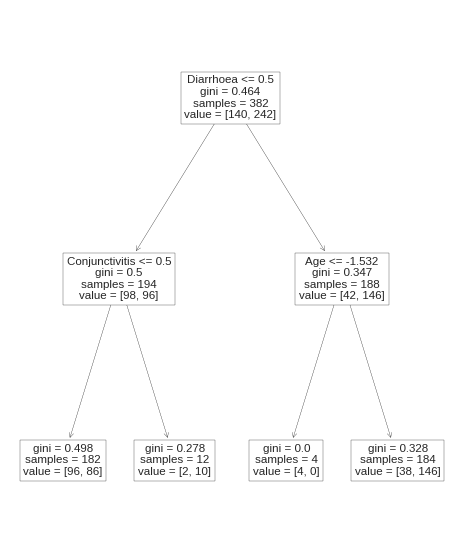

In [126]:

tree.plot_tree(clf2q,feature_names=X.columns)
fig = matplotlib.pyplot.gcf()
#fig.savefig('tree_2_question.png')
plt.show()


DecisionTreeClassifier:
On training we get an Accuracy 0.9502617801047121, an AUC 0.9381641086186541 and F1 score 0.9616161616161617 
For test we get an Accuracy 0.59375, an AUC 0.5524590163934426 and F1 score 0.688


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


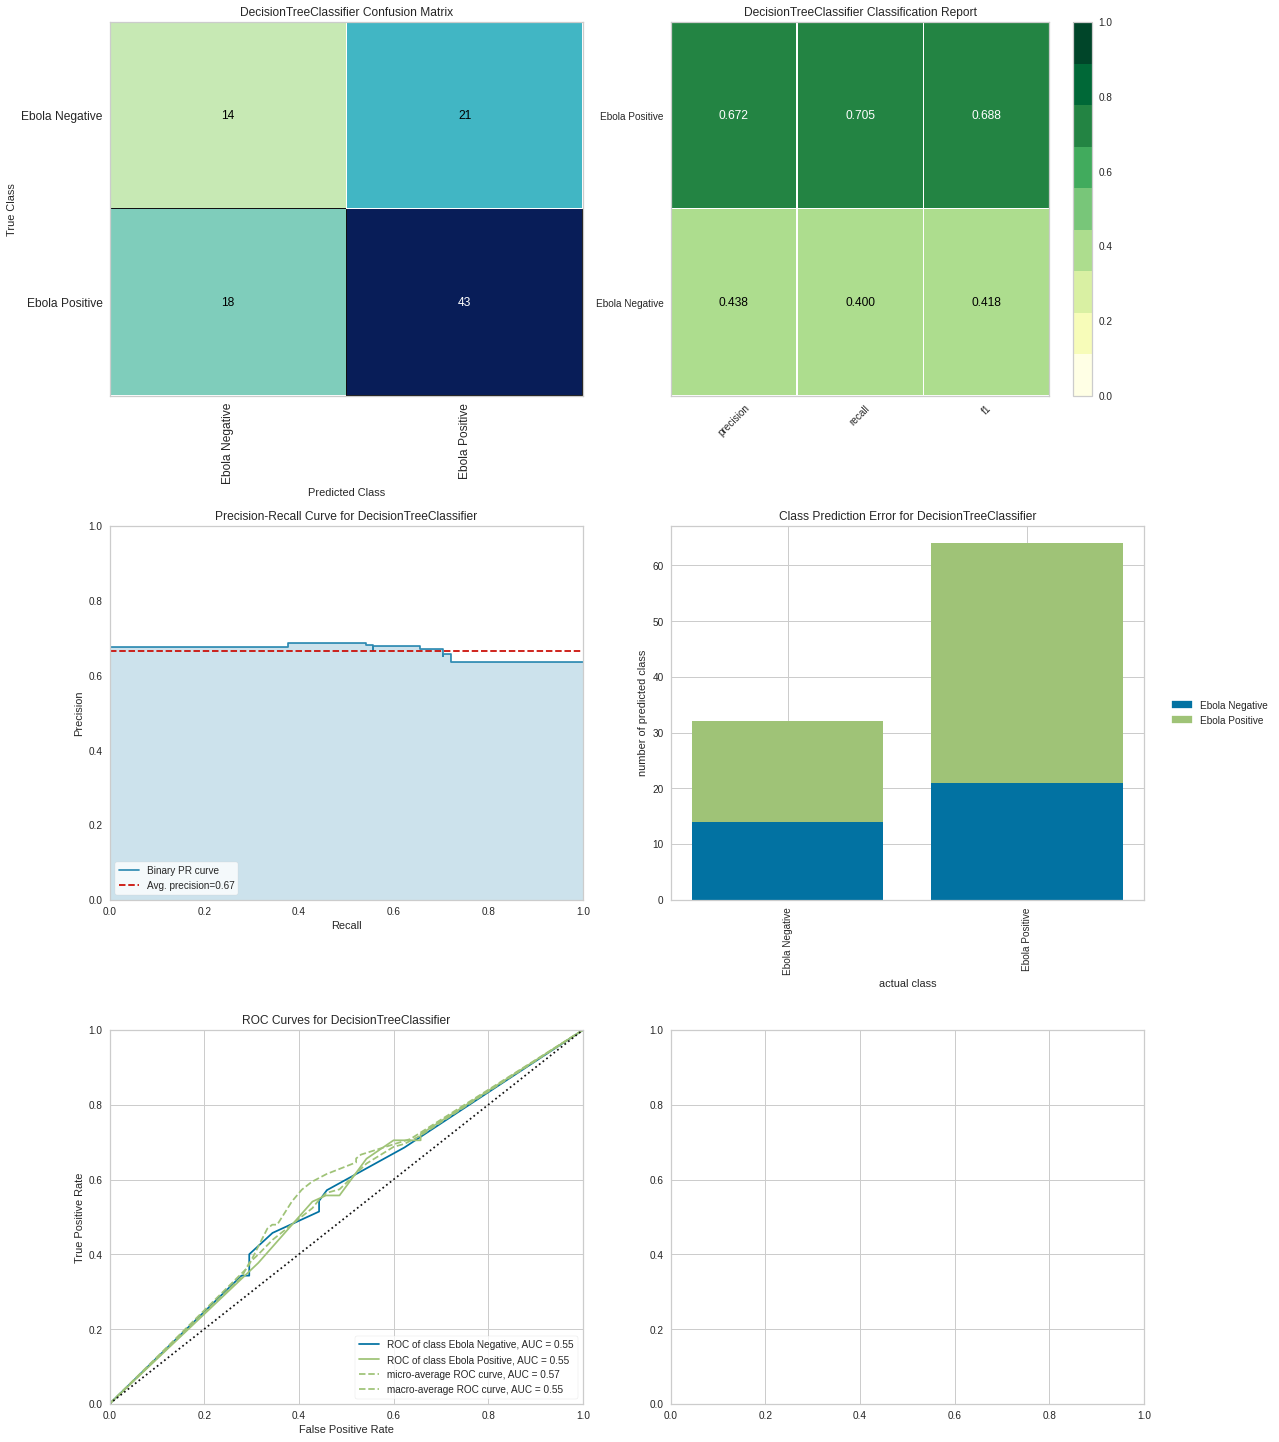

Don't have feature importance




In [127]:
# Now with ten questions 

clf10q = tree.DecisionTreeClassifier(max_depth=10)
clf10q = clf10q.fit(X_ebo_train, y_ebo_train)

score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, clf10q)


Decision trees are easy to overfit (refer to result just above), let's use Random forest and tune its hyper-parameters

# Random Forest

RandomForestClassifier:
On training we get an Accuracy 0.7617801047120419, an AUC 0.7036009445100355 and F1 score 0.8305400372439479 
For test we get an Accuracy 0.65625, an AUC 0.5711943793911007 and F1 score 0.7659574468085107


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


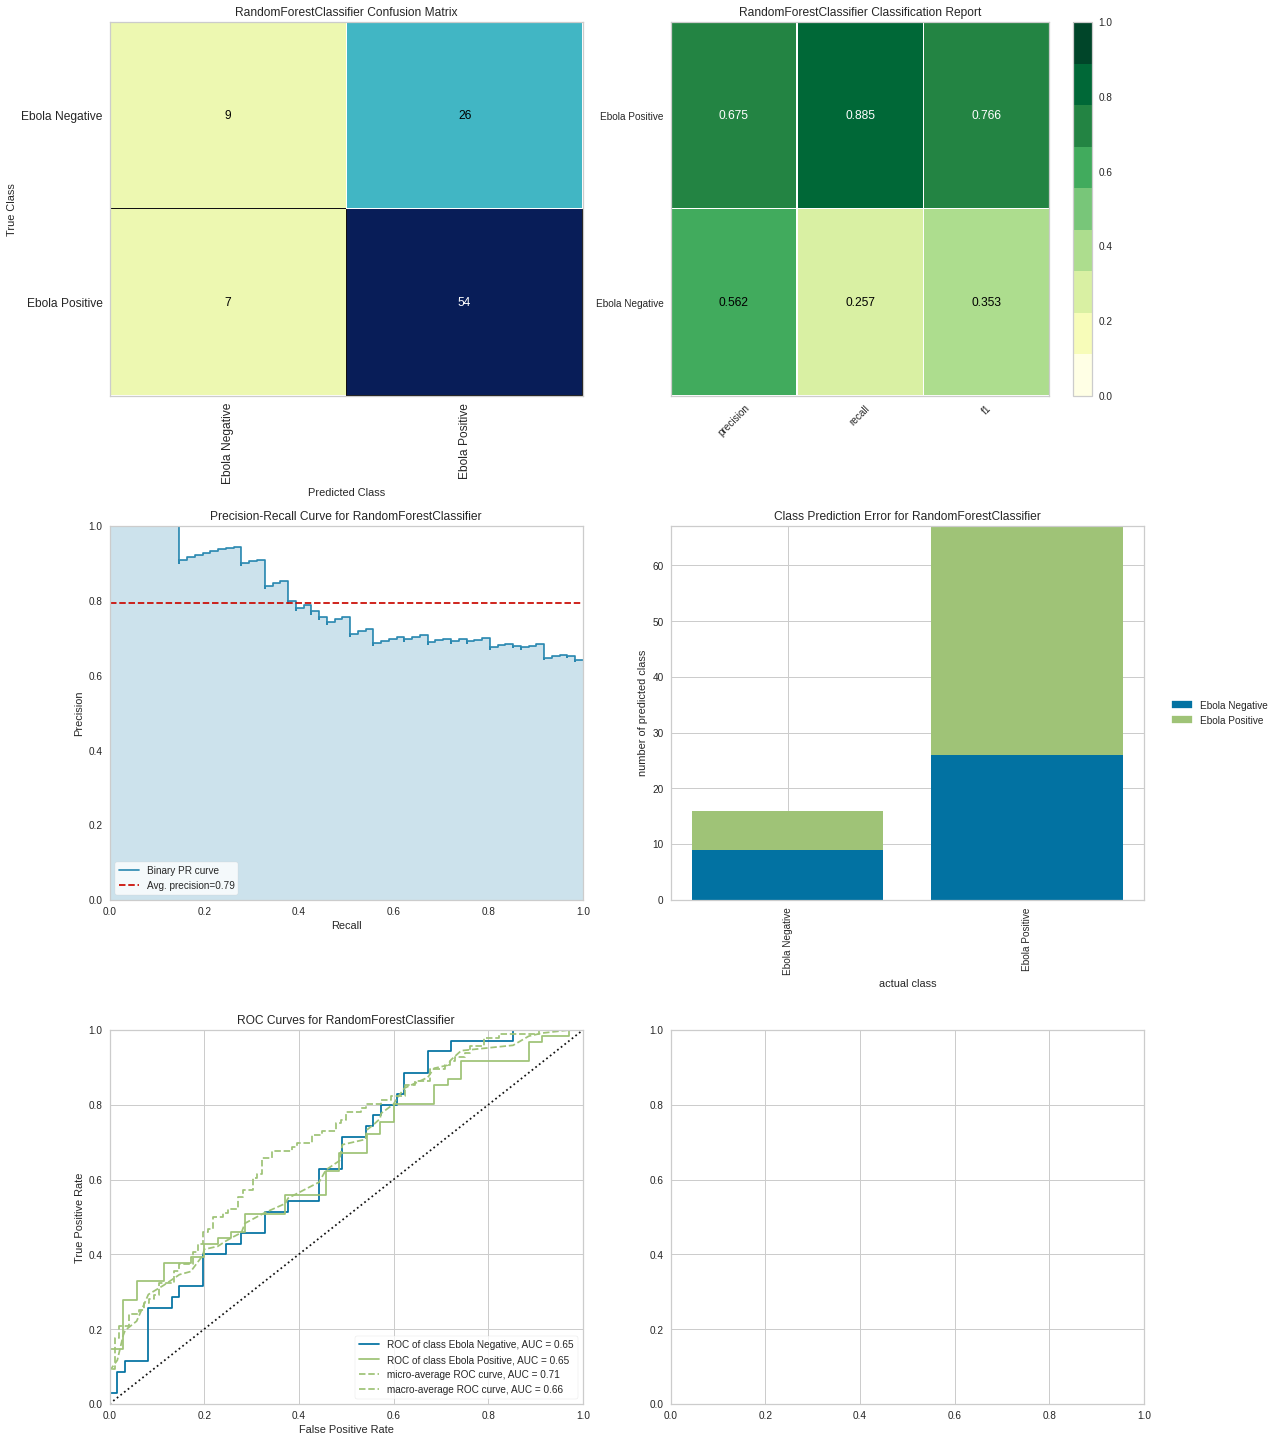

Don't have feature importance




In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# What happens when you only can ask five question ?
clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state = 123)

clf = clf.fit(X_ebo_train, y_ebo_train)

score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, clf)



#### Hyper-parameter tuning 

In [129]:
from sklearn.model_selection import GridSearchCV
param_test = {
    'n_estimators':[i for i in range(5, 20)],
    'max_depth':[i for i in range(3, 15)],
    'min_samples_split':[i for i in range(2, 7)]
}
clforest = RandomForestClassifier(random_state = 123)


In [130]:

gsearch = GridSearchCV(
    estimator= clforest,
    param_grid= param_test,
    scoring='roc_auc',
    n_jobs=4,
    iid=False,
    cv=5
)
gsearch.fit(X_ebo_train, y_ebo_train)


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             iid=False, n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                         'min_samples_split': [2, 3, 4, 5, 6],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                          16, 17, 18, 19]},
             scoring='roc_auc')

In [131]:
gsearch.best_params_

{'max_depth': 9, 'min_samples_split': 4, 'n_estimators': 19}

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomForestClassifier:
On training we get an Accuracy 0.9345549738219895, an AUC 0.9212514757969303 and F1 score 0.9494949494949494 
For test we get an Accuracy 0.6666666666666666, an AUC 0.6281030444964871 and F1 score 0.746031746031746


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


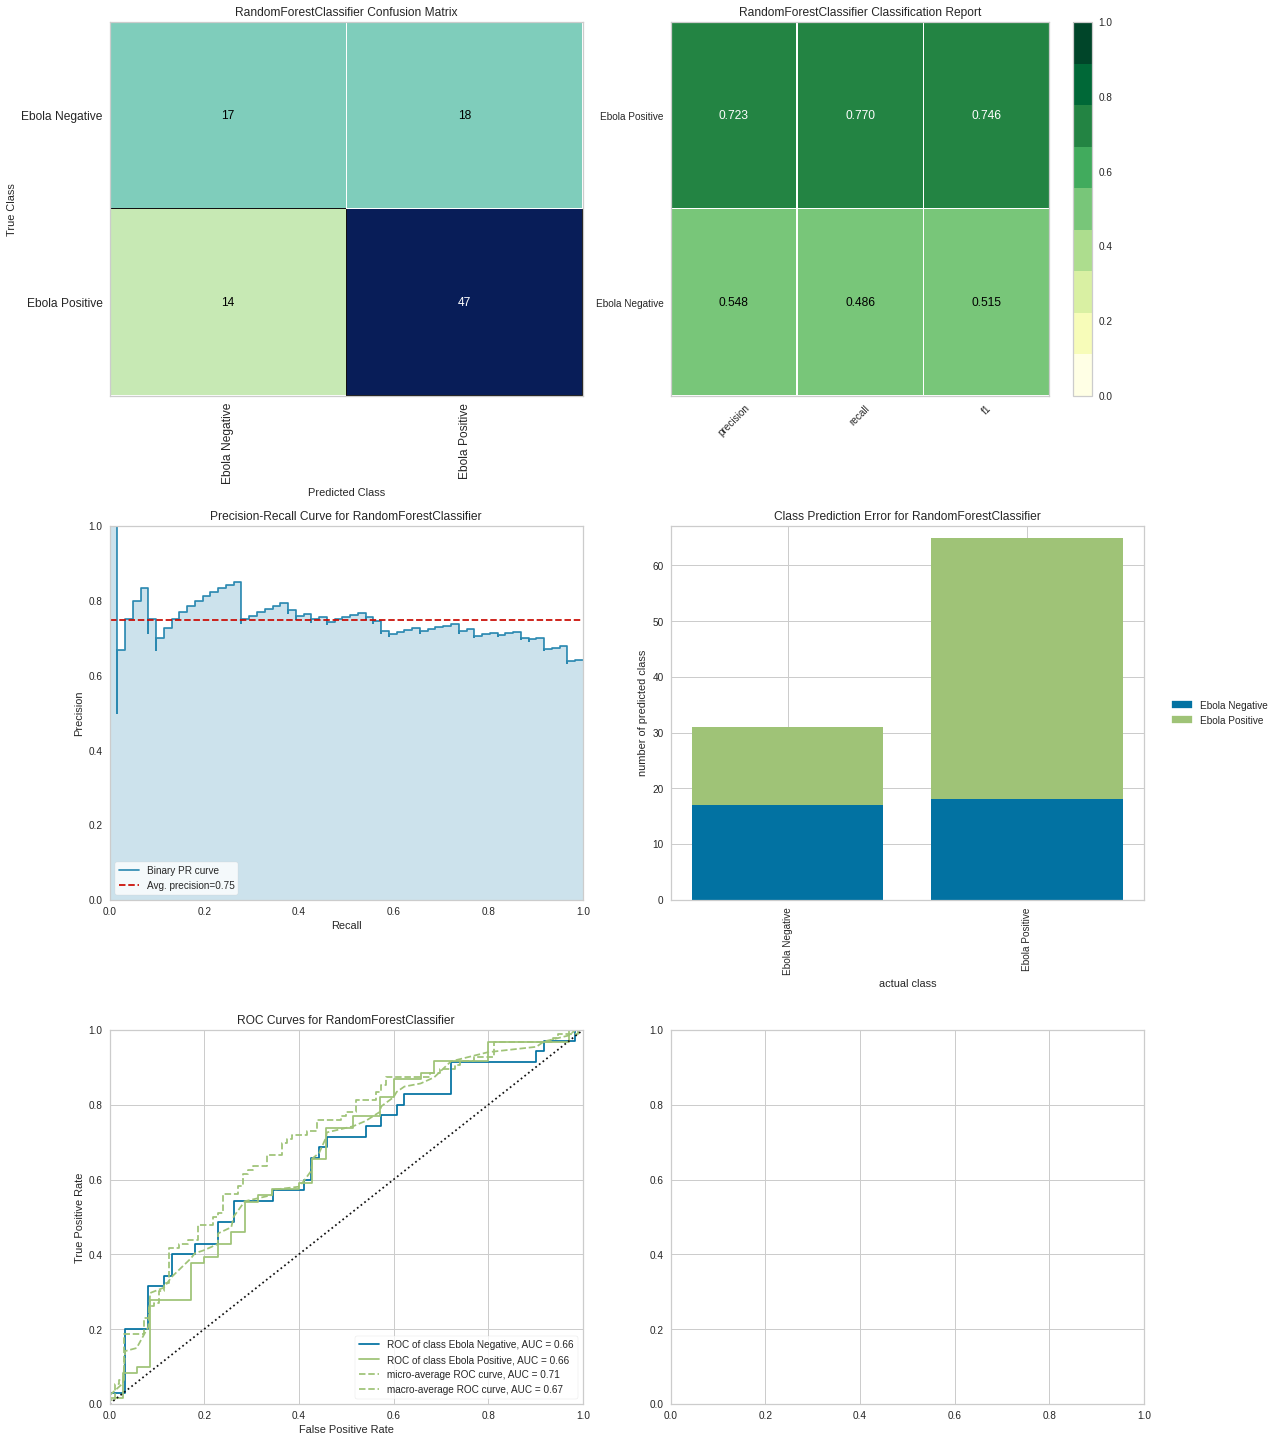

Don't have feature importance




In [132]:

clf_best = RandomForestClassifier(n_estimators=19, max_depth=9, min_samples_split=4)

clf_best = clf_best.fit(X_ebo_train, y_ebo_train)
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, clf_best)



Again great signs of overfitting 

Let us add a hyper-parameter which may help with the overfitting 


In [133]:
parameters = {'n_estimators': [2,3,4,5,6], 'max_depth' : [3,4,5,6, 7, 8],
              'min_samples_split': range(2,6), 'max_leaf_nodes': range(2,5)}

ebo_forest_classifier = RandomForestClassifier()
clf = GridSearchCV(ebo_forest_classifier, parameters, scoring = 'roc_auc', n_jobs=-1)
clf.fit(X_ebo_train, y_ebo_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'max_leaf_nodes': range(2, 5),
                         'min_samples_split': range(2, 6),
                         'n_estimators': [2, 3, 4, 5, 6]},
             scoring='roc_auc')

In [134]:
clf.best_params_

{'max_depth': 8,
 'max_leaf_nodes': 4,
 'min_samples_split': 5,
 'n_estimators': 6}

RandomForestClassifier:
On training we get an Accuracy 0.6780104712041884, an AUC 0.5682408500590319 and F1 score 0.793969849246231 
For test we get an Accuracy 0.5833333333333334, an AUC 0.46510538641686183 and F1 score 0.7333333333333333


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


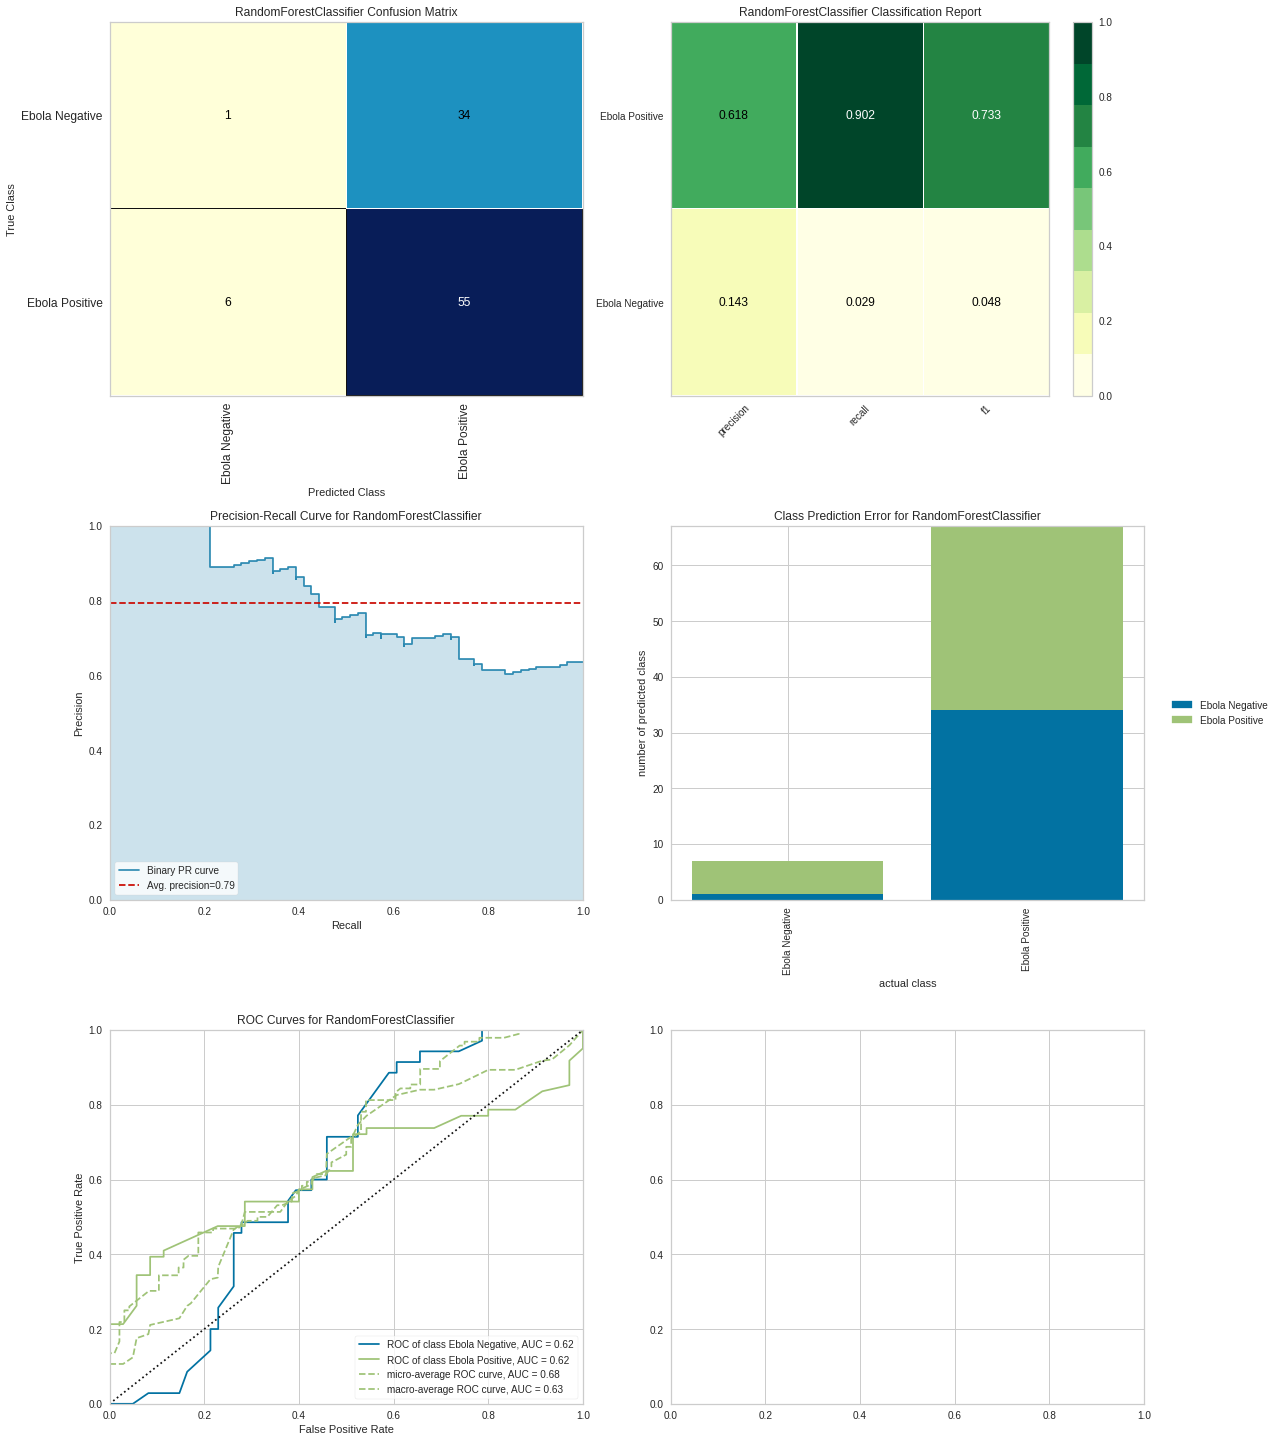

Don't have feature importance




In [135]:
ebo_forest_classifier = RandomForestClassifier(n_estimators =clf.best_params_['n_estimators'],
                                              max_depth = clf.best_params_['max_depth'],
                                              min_samples_split = clf.best_params_['min_samples_split'],
                                              max_leaf_nodes = clf.best_params_['max_leaf_nodes'])

# Give score to model
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, ebo_forest_classifier)

Again, the model shows signs of overffing. 

In [136]:
### This is to  output as a tree the random forest classifier


dot_data_forest =export_graphviz(
    ebo_forest_classifier.estimators_[1],
    out_file=None,
    feature_names=X.columns,
    class_names=['Not a case', 'Confirmed'],
    label='root',
    filled=True,
    rounded=True,
    impurity=False,
    proportion=True
)
graph_forest = graphviz.Source(dot_data_forest)
#graph_forest.render("Decision_forest_1")


'Decision_forest_1.pdf'

## XGBoost 

(eXtreme Gradient Boosting) : Advanced implementation of gradient boosting algorithm

__Import libraries__

In [137]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib.pylab import rcParams
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance


##### __Hyperparameters__
__BOOSTER PARAMETER__
- _learning rate_:         eta = [[0,1]] (Use CV)
- _min_child_weigt_:   (determines sum of weights of all weights required in a child) Controls overfitting, high values prevent models to learn from highly specific samples
(Use CV)
- _max_depth_: determines depth of tree [3-10] (Use CV)
- _subsample_: % of samples used per tree, low value may lead to underfitting [0.5-1]
- _colsample_bytree_: % features used per tree, high value, then overfitting [0.5-1]


__Learning Task Parameters__
- _objective_: (binary:logistic )logistic regression for binary classification, returns predicted probability (not class)
- _eval_metric_= "error" Binary classification 0.5 threshold 
- _n_estimators_: number of trees to built




__To penalize__
- _gamma_: The larger gamma is, the more conservative the algorithm will be. (loss required to split)
- _alpha_: L1 regularization
- _lambda_: L2 reg, smoother than L1


In [138]:
def modelfit(alg,x_train, y_train, x_test, y_test,useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds,show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult.shape[0])
    
    #Fit the algorithm on the data
    eval_set = [(x_train, y_train), (x_test, y_test)]
    alg.fit(x_train, y_train,eval_metric='error', eval_set=eval_set, verbose=False)

        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("F1 accuracy score (train): ",metrics.f1_score(y_train,model.predict(x_train)))
    print ("Accuracy (train): %.3f" %metrics.accuracy_score(y_train, dtrain_predictions))
    print("Accuracy (test): %.3f" %metrics.accuracy_score(y_test, alg.predict(x_test)))
    print("F1 accuracy score (test): ",metrics.f1_score(y_test,model.predict(x_test)))
    print("AUC Accuracy (train): %f"%metrics.roc_auc_score(y_train, dtrain_predprob))
    print("AUC Accuracy (test): %f"%metrics.roc_auc_score(y_test, alg.predict_proba(x_test)[:,1]))
 
    # Plot the important features
    xgb.plot_importance(alg)

    
# Code inspired from : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

## Let's try one by one paramter tuning

General Approach for Parameter Tuning

We will use an approach similar to that of GBM here. The various steps to be performed are:

    Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
    
    Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
    
    Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
    Lower the learning rate and decide the optimal parameters .


In [139]:
print("This gives an idea of the scale_pos_weight value  ",sum(y_ebo_train==1)/sum(y_ebo_train==0))

This gives an idea of the scale_pos_weight value   1.7285714285714286


In [140]:
#############
# tuning n_estimators (number of trees)
#############

model_tune = xgb.XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,
                         gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                             nthread=4, seed=123, reg_lambda = 0,scale_pos_weight = 1.78)



param_test1 = {'n_estimators':range(2,20,2)
}
gsearch1 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_ebo_train,y_ebo_train)
gsearch1.best_params_, gsearch1.best_score_


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'n_estimators': 16}, 0.6678146258503401)

In [141]:
# Set parameters
model_tune.set_params(n_estimators=gsearch1.best_params_['n_estimators'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0,
              scale_pos_weight=1.78, seed=123, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

#### GridSearchCV

Instead of looking at one parameter at a time, let us use GridSearch

In [142]:
################
# Tune max_depth, et min_child weight
################


param_test1 = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = 
                        model_tune, 
                                param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_ebo_train,y_ebo_train)
gsearch1.best_params_, gsearch1.best_score_


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 3, 'min_child_weight': 3}, 0.6727875971817298)

In [143]:
# New optimal, let's set those instead 
model_tune.set_params(max_depth=gsearch1.best_params_['max_depth'],min_child_weight=gsearch1.best_params_['min_child_weight'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0,
              scale_pos_weight=1.78, seed=123, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

In [144]:
################
# Tune gamma
################


param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_ebo_train,y_ebo_train)
gsearch3.best_params_, gsearch3.best_score_


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'gamma': 0.9}, 0.6733539844509232)

In [145]:
# Set gamma parameter
model_tune.set_params(gamma=gsearch3.best_params_['gamma'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=0.9,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0,
              scale_pos_weight=1.78, seed=123, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

### Let's have  a look at the model again 
modelfit(model_tune, X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test)
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, model_tune)

In [146]:
################
# Tune subsample (% of sample used in trees) and colsample_bytree (% features used by trees)
################

param_test4 = {
 'subsample':[i/10.0 for i in range(5,10)],
 'colsample_bytree':[i/10.0 for i in range(5,10)]
}
gsearch4 = GridSearchCV(estimator =model_tune, 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_ebo_train,y_ebo_train)
gsearch4.best_params_, gsearch4.best_score_



/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'colsample_bytree': 0.5, 'subsample': 0.6}, 0.6959912536443148)

In [147]:
# Let's try smaller values around the ones found
model_tune.set_params(subsample=gsearch4.best_params_['subsample'],colsample_bytree=gsearch4.best_params_['colsample_bytree'])


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=0.9,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0,
              scale_pos_weight=1.78, seed=123, subsample=0.6, tree_method=None,
              validate_parameters=None, verbosity=None)

In [148]:
param_test5 = {
 'subsample':[i/100.0 for i in range(70,80,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch5 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_ebo_train,y_ebo_train)
gsearch5.best_params_, gsearch5.best_score_

# It changed a little, we pick these instead

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'colsample_bytree': 0.75, 'subsample': 0.7}, 0.6765139091350825)

In [149]:
# Set new parameters "optimal parameters"
model_tune.set_params(subsample=gsearch5.best_params_['subsample'],colsample_bytree=gsearch5.best_params_['colsample_bytree'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.75, gamma=0.9,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0,
              scale_pos_weight=1.78, seed=123, subsample=0.7, tree_method=None,
              validate_parameters=None, verbosity=None)

In [150]:
################
# reg_lambda: L2 reg tuning
################


param_test6 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_ebo_train,y_ebo_train)
gsearch6.best_params_, gsearch6.best_score_

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'reg_lambda': 0.01}, 0.676662718658892)

In [151]:
# Let's try tigher values around the one found

param_test7 = {
 'reg_lambda': np.arange(0,1,0.01)
}
gsearch7 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_ebo_train,y_ebo_train)
gsearch7.best_params_, gsearch7.best_score_


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'reg_lambda': 0.04}, 0.6787339042759961)

In [152]:
model_tune.set_params(reg_lambda=gsearch7.best_params_['reg_lambda'])

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.75, gamma=0.9,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=16, n_jobs=None, nthread=4, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=0.04,
              scale_pos_weight=1.78, seed=123, subsample=0.7, tree_method=None,
              validate_parameters=None, verbosity=None)

XGBClassifier:
On training we get an Accuracy 0.6544502617801047, an AUC 0.531582054309327 and F1 score 0.7843137254901961 
For test we get an Accuracy 0.6666666666666666, an AUC 0.5428571428571429 and F1 score 0.7922077922077922


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


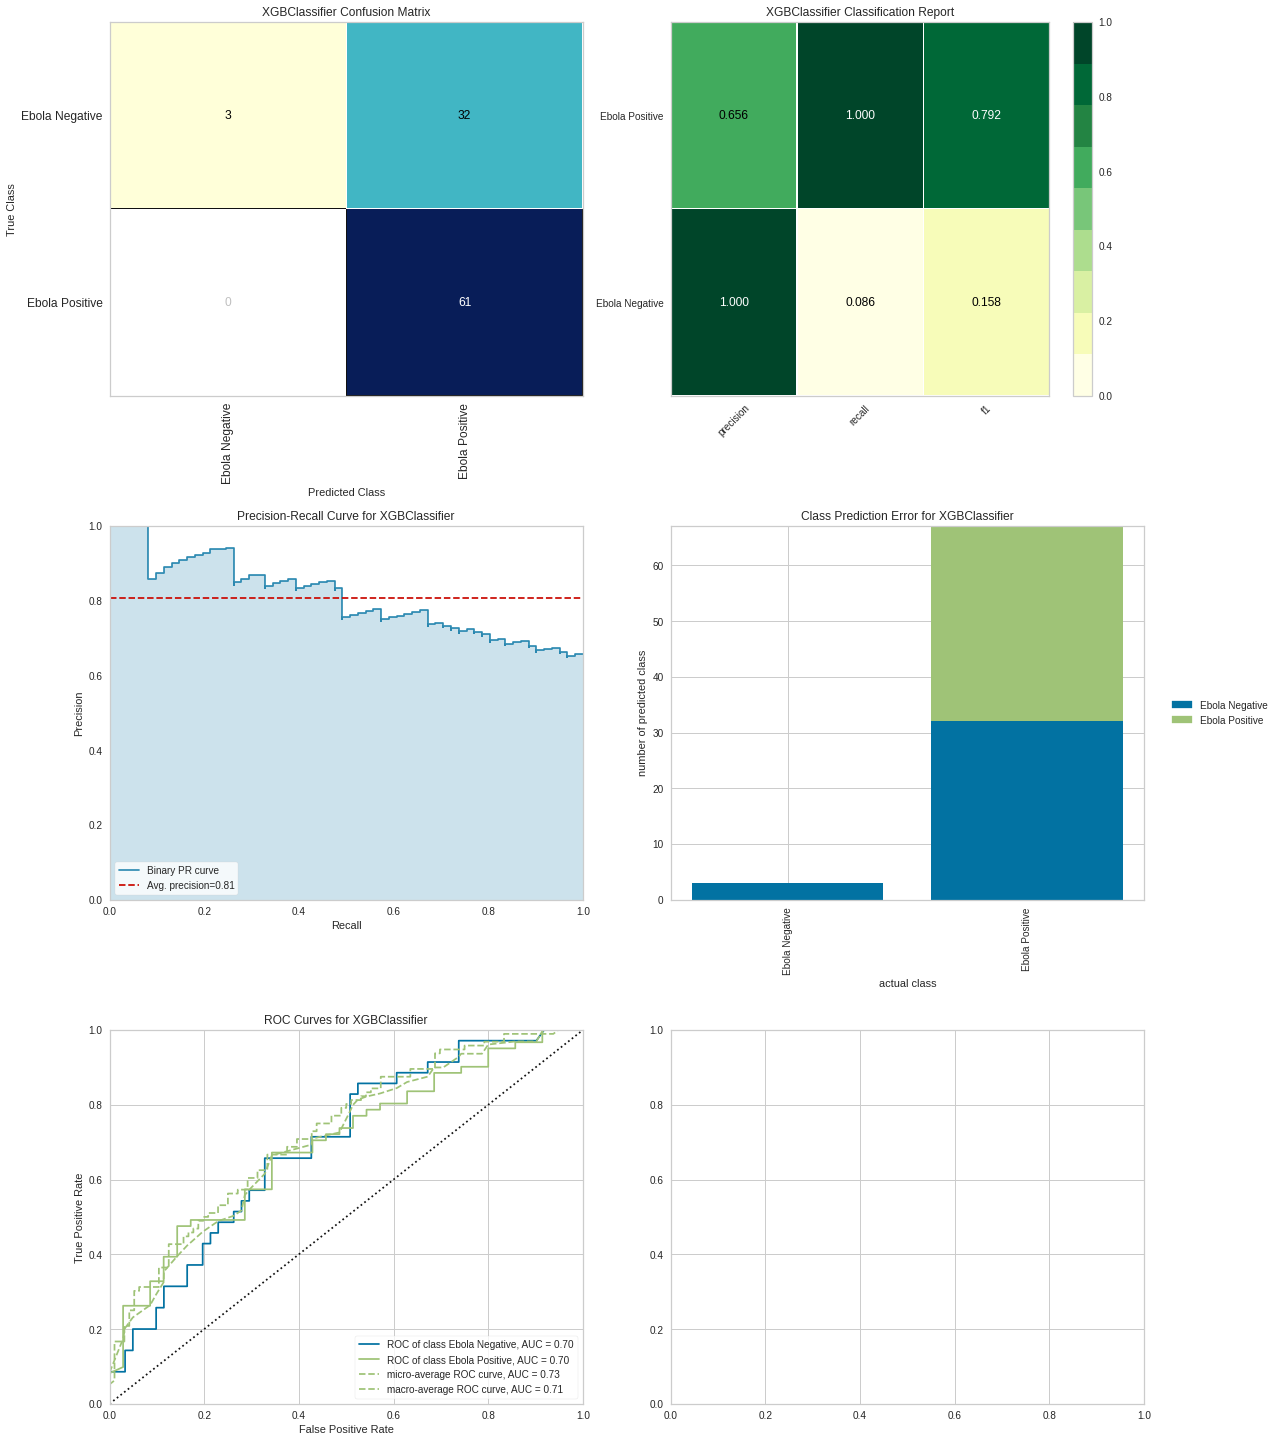

Don't have feature importance




In [153]:
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, model_tune)

In [154]:
# Last step is the learning rate




param_test8 = {
 'learning_rate': np.arange(0.01,0.3,0.01)
}
gsearch8 = GridSearchCV(estimator = model_tune, 
 param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch8.fit(X_ebo_train,y_ebo_train)
gsearch8.best_params_, gsearch8.best_score_


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'learning_rate': 0.08}, 0.6804224368318756)

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier:
On training we get an Accuracy 0.6570680628272252, an AUC 0.5336481700118064 and F1 score 0.7862969004893964 
For test we get an Accuracy 0.65625, an AUC 0.5285714285714286 and F1 score 0.7870967741935483


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


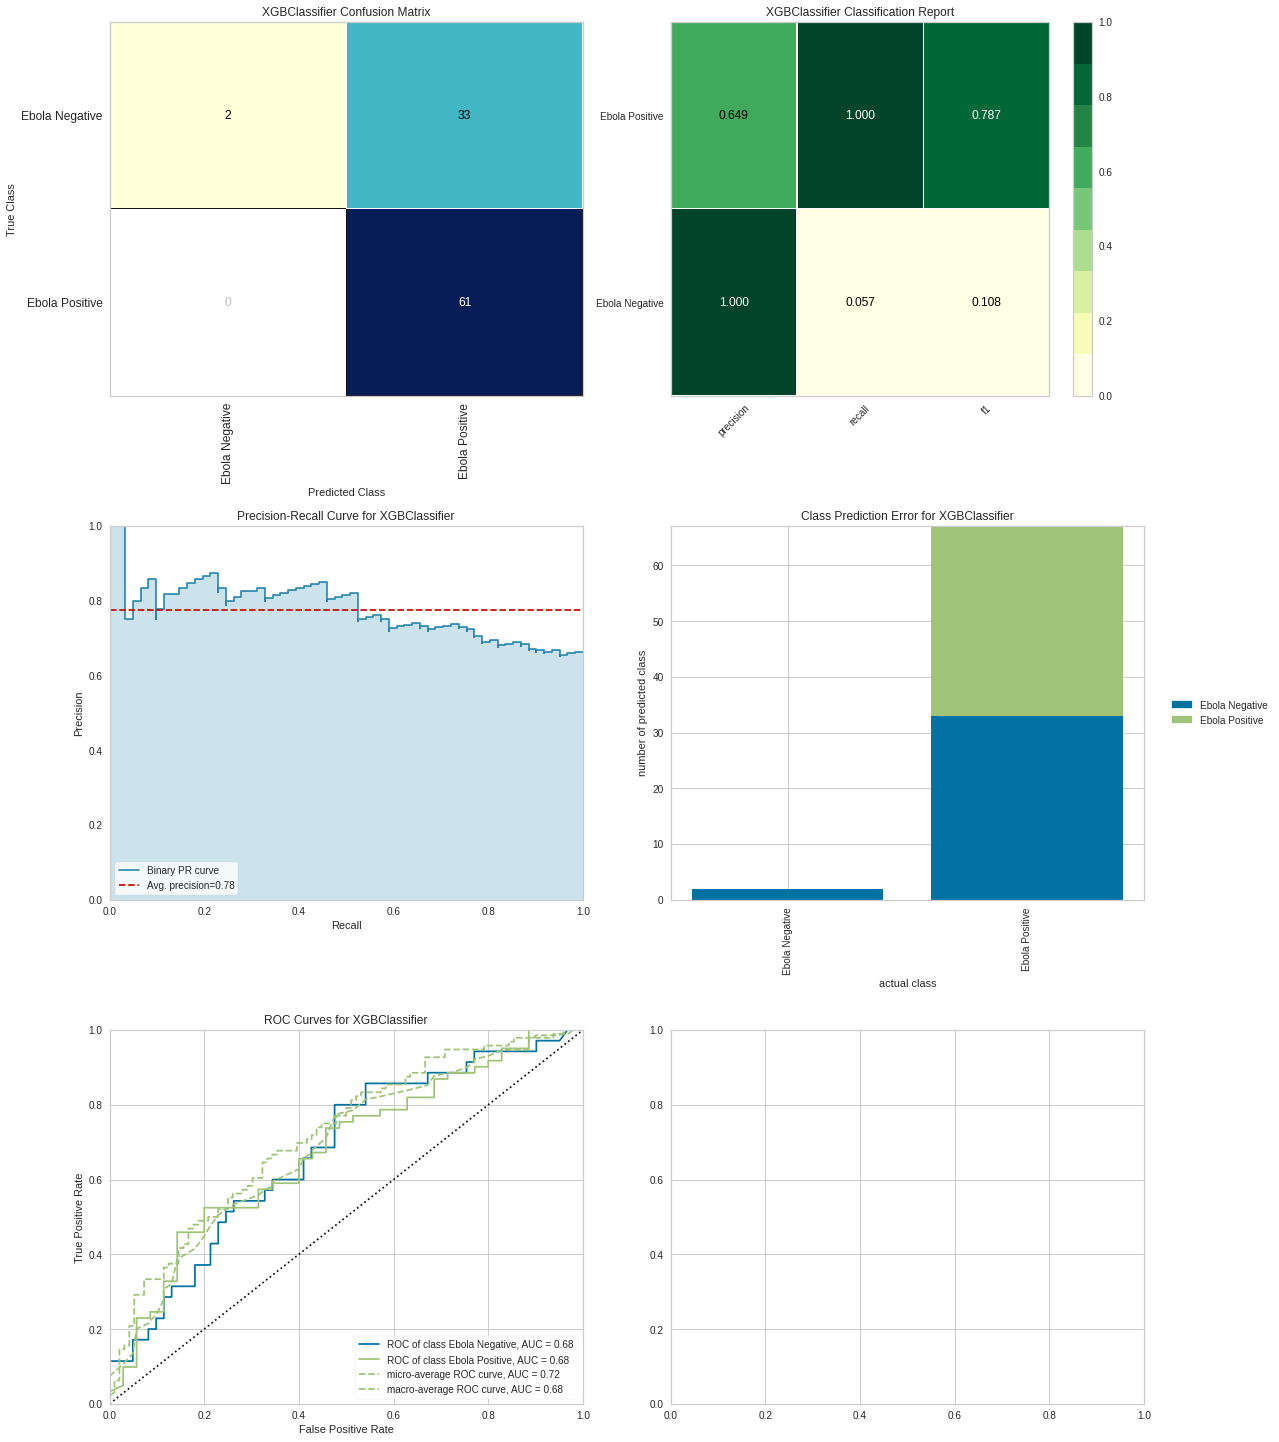

Don't have feature importance




In [155]:
# Set the new learning rate (final parameter)
model_tune.set_params(learning_rate=gsearch8.best_params_['learning_rate'])

# Final model

score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, model_tune)

#### Instead of cross validating, one or two parameters at a time, let's do many 


In [156]:


param_test = {'learning_rate': np.arange(0.01,0.3,0.1), 'n_estimators':np.arange(9,20,5),'max_depth':[2,3,4], 'gamma': [i/10.0 for i in range(0,3)],
               'min_child_weight':np.arange(5,8,1),'subsample': [i/100.0 for i in range(70,80,5)], 'colsample_bytree': [i/100.0 for i in range(65,80,5)], 
                  'reg_lambda':np.arange(0,7,1)}

gsearch = GridSearchCV(estimator = 
                        XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1,
                         gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                             nthread=4, seed=123, reg_lambda = 0,scale_pos_weight = 1.78), 
                                param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5,verbose = False)
gsearch.fit(X_ebo_train,y_ebo_train)
gsearch.best_params_, gsearch.best_score_



/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'colsample_bytree': 0.7,
  'gamma': 0.1,
  'learning_rate': 0.21000000000000002,
  'max_depth': 3,
  'min_child_weight': 5,
  'n_estimators': 19,
  'reg_lambda': 2,
  'subsample': 0.75},
 0.7016657555879495)

In [157]:
# Model with optimized set of parameters 
model_CV = XGBClassifier( learning_rate =0.11, n_estimators=19, max_depth=3,
                         min_child_weight=5, gamma=0.1, subsample=0.75, colsample_bytree=0.7,
                         objective= 'binary:logistic', nthread=4, scale_pos_weight=1.78, reg_lambda = 2,seed=123)

# Model report with CV
#modelfit(model_CV, x_train, y_train, x_test, y_test)

/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


XGBClassifier:
On training we get an Accuracy 0.6596858638743456, an AUC 0.5357142857142857 and F1 score 0.7882736156351792 
For test we get an Accuracy 0.65625, an AUC 0.5285714285714286 and F1 score 0.7870967741935483


/home/lavinia/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


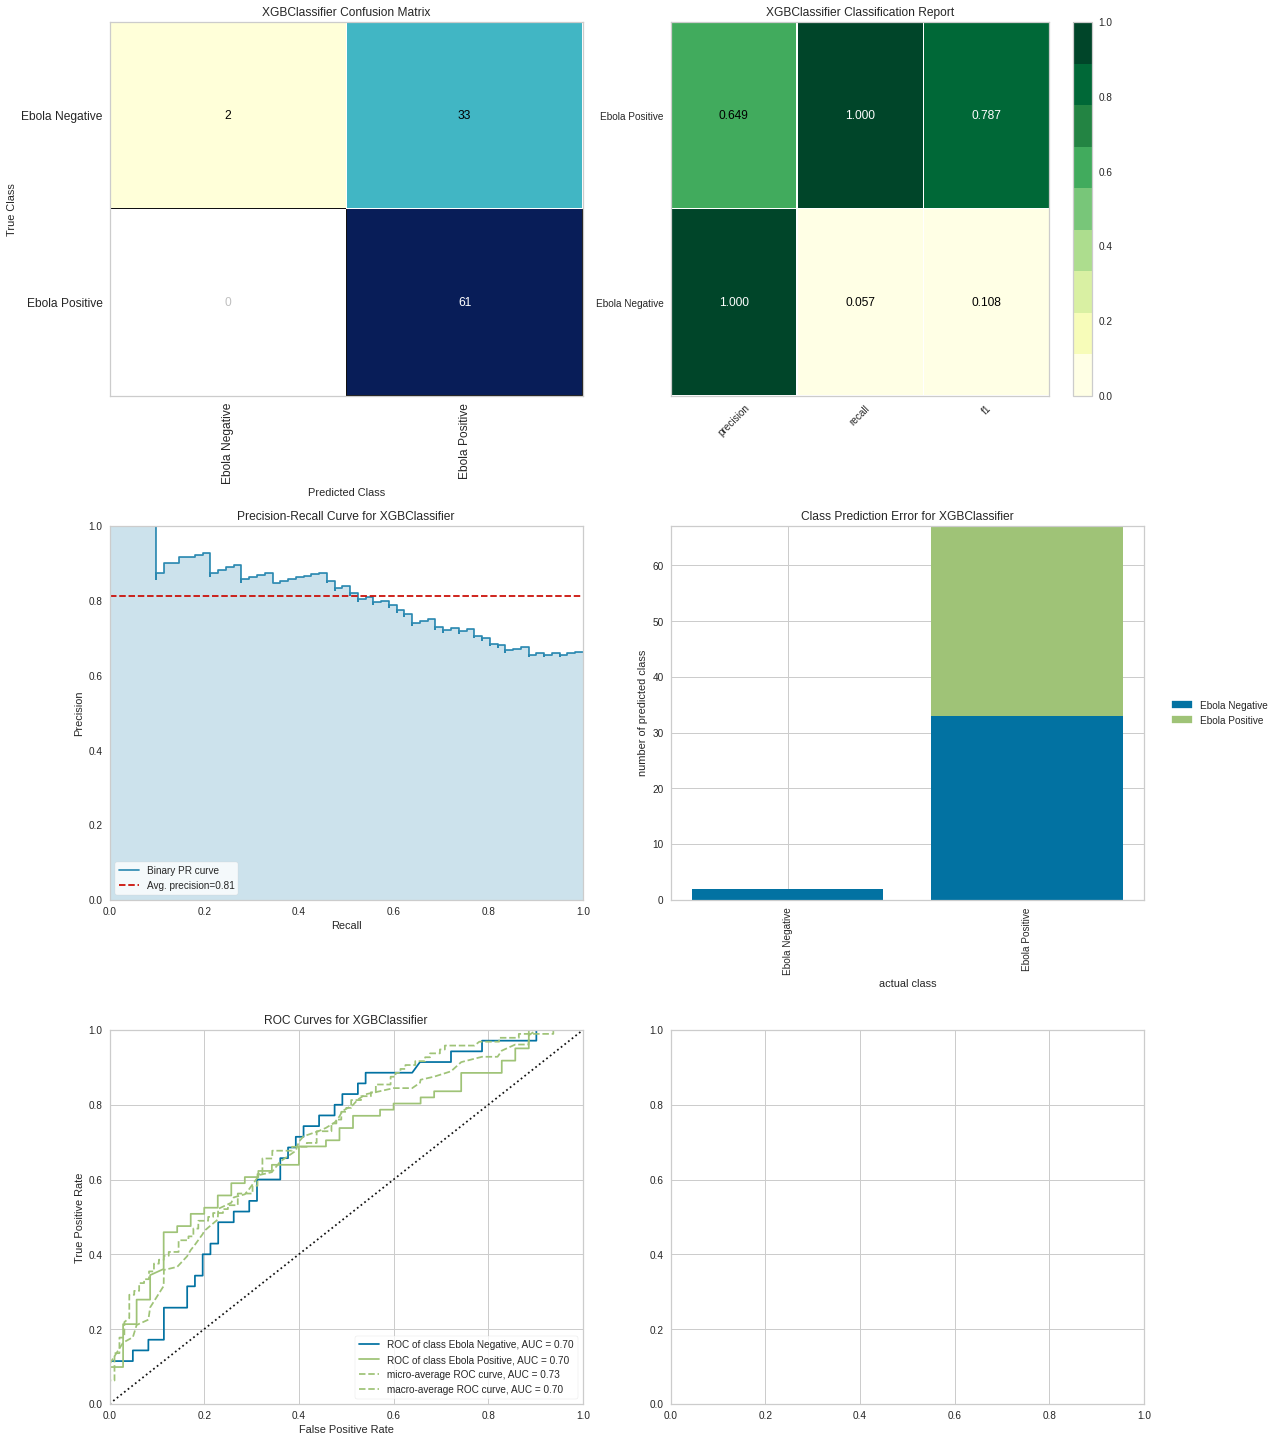

Don't have feature importance




In [158]:
score_model(X_ebo_train, y_ebo_train, X_ebo_test, y_ebo_test, model_CV)

In [159]:
cumulator.off() 


In [160]:
cumulator.computation_costs()

21.579302389870087